<a href="https://www.kaggle.com/code/catalystcooperative/03-eia-930-sanity-checks?scriptVersionId=235662903" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Imputed Hourly Demand in PUDL
## Background
PUDL data includes multiple sources for hourly electricity demand data reported at various levels of spatial granularity. Namely, [FERC Form 714](https://catalystcoop-pudl.readthedocs.io/en/latest/data_sources/ferc714.html) contains hourly demand by planning area, while [EIA Form 930](https://catalystcoop-pudl.readthedocs.io/en/latest/data_sources/eia930.html) contains hourly demand by Balancing Authority (BA) and BA subregion. In order to make this data more readily usable for cases which value completeness and smoothness of the data, we've developed a pipeline for imputing missing and anomalous data points. The pipeline follows following set of steps:

1. Transform data into expected shape (a matrix where each row is a unique entity like a BA or subregion and each column is one hour of demand).
2. Identify anomalous data points and flag these for imputation.
3. Run imputation on 1-year chunks of data.
4. Reshape back to original structure with added columns for imputed demand and a column of codes indicating which values were flagged and why.

Our imputation pipeline is adapted from this [implementation](https://github.com/truggles/EIA_Cleaned_Hourly_Electricity_Demand_Code) by [Tyler Ruggles](https://github.com/truggles) and [Alicia Wongel](https://github.com/awongel) (Alicia also provided valuable input and testing during the development process). We will refer to this implementation as the "baseline", which we use as a reference for comparison, but it should be understood that this is not groundtruth data, which does not exist. Despite the reference implementation being specifically developed for EIA 930, we initially adapted it for FERC 714 data, and only recently generalized our implementation to work with EIA 930. Both implementations use the exact same approach to the "flagging" portion of the pipeline, but we use a different method for the actual imputation. We changed this portion of the pipeline, because we found our method is significantly faster (often 100-1000x), which is particularly important for us given that we have multiple imputations that we are running every single night. Due to these differences, we obviously don't expect our results to be identical, but we do expect them 

During this generalization process, we standardized the structure and naming conventions for imputed data, and developed significant tooling for analyzing and validating the data. This notebook will demonstrate how to access this data, and what we've done to feel confident in our imputation. For a detailed description of our timeseries imputation methods, see the [docs](https://catalystcoop-pudl.readthedocs.io/en/latest/methodology/timeseries_imputation.html).

## Available Data
### General
- `core_pudl__codes_imputation_reasons` - Describes reasons a value was "flagged" for imputation

### FERC Form 714
- `out_ferc714__hourly_planning_area_demand` - Hourly demand by planning area

### EIA Form 930
- `out_eia930__hourly_operations` - Hourly demand by BA
- `out_eia930__hourly_subregion_demand` - Hourly subregion demand

## Approach to Validating Performance
When imputing data it can be difficult to validate the performance as the data we are imputing is inherently "bad", and so we will never know what the true values should be. To deal with this limitation, we've applied several different approaches to validation, which we use in conjunction to feel confident in our implementation.

### The Eye Test
The first step to validation is to simply visually inspect sections of data to look for obvious issues. To do this, we plot sections of data and visually compare the imputed and reported data. While this is a basic approach it's an incredibly valuable way to quickly assess performance and check intuitive expectations.

### Compare to Baseline
Our second approach is to compare our results to the baseline implementation linked above. Since we have an existing example of imputed EIA 930 data, we are able to use this as a comparison for our results. This, of course, assumes the original implementation is performing well, but it at least gives confidence that we have not significantly diverged from this reference.

### Impute Simulated Data
Finally, we have developed a simulation pipeline, which provides a more quantitative approach to validating performance. This approach finds sections of data where no values were flagged for imputation, and flags a number of these for a simulated imputation. This way, we can impute values where we have a ground truth for comparison.

### High-level Overview
In the vast majority of cases, we see only the occasional data point getting flagged for imputation. When we apply any of the above validation approaches to cases like this, we find performance is very good. For this reason, we'll focus most of our analysis on cases where a relatively high proportion of values are flagged for imputation. While these cases are not necessarily representative of the general, they show us how the imputation performs in more challenging scenarios, which are where we are most concerned.

## Notebook Setup

In [2]:
!pip install matplotx --quiet

In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import requests
import zipfile
from datetime import timedelta
from io import BytesIO

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import matplotlib
import matplotx
from pandas.tseries.offsets import MonthEnd

matplotlib.style.use(matplotx.styles.onedark)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Data Access
 All of the tables listed above are available in PUDL nightly builds, and will be updated with new data as it becomes available. All of these tables can be accessed as a parquet file from a link like:

```
s3://pudl.catalyst.coop/nightly/{table_name}.parquet
```

Below we'll demonstrate loading a table from nightly builds into a Pandas DataFrame with the `core_pudl__codes_imputation_reasons` table.

In [4]:
def get_s3_nightly(table: str) -> pd.DataFrame:
    """Read data from our AWS open data registry S3 bucket."""
    return pd.read_parquet(f"s3://pudl.catalyst.coop/nightly/{table}.parquet")

get_s3_nightly("core_pudl__codes_imputation_reasons")

code                                        description
0             missing_value    Indicates that reported value was already NULL.
1          anomalous_region  Indicates that value is surrounded by flagged ...
2          negative_or_zero               Indicates value is negative or zero.
3             identical_run  Indicates value is part of an identical run of...
4            global_outlier  Indicates value is greater or less than n time...
5   global_outlier_neighbor         Indicates value neighbors global outliers.
6        local_outlier_high  Indicates value is a local outlier on the high...
7         local_outlier_low  Indicates value is a local outlier on the low ...
8              double_delta  Indicates value is very different from neighbo...
9              single_delta  Indicates value is significantly different fro...
10                 bad_year  Indicates the entire year of data for a respon...
11                simulated  Used for scoring imputation using simulated da...

## Visualizing Imputed Data
An important part of the development process when creating our imputation pipeline was visual spot checking of imputed data. This allows us to qualitatively judge performance when it is often difficult to impossible to produce quantitative measurements. We'll implement a function below to identify sections of data where a relatively high proportion of values were flagged. By default this function will look for months of data where between 10-25% of values were flagged. This range tends to be interesting, as there's enough "bad" values to challenge the imputation, but not so many that there's insufficient "good" data for reference. This function will also filter to BA's/subregions where the magnitude of demand is relatively high. We do this because entities with low demand tend to be messy and less interesting to our users.

Next, we'll implement a function to actually plot the interesting regions of data we identify. This function will take a set of ID's to identify a specific BA or subregion, and a date range to plot.

### Identify regions of interest

In [5]:
def get_imputation_rate(
    df: pd.DataFrame,
    idx_cols: list[str],
    flag_col: str = "demand_imputed_pudl_mwh_imputation_code",
    imputed_col: str = "demand_imputed_pudl_mwh",
    min_median_demand: float = 300,
    min_imputation_rate: float = 0.1,
    max_imputation_rate: float = 0.25,
    num_samples: int = 2,
    time_period: str | None = "month",
) -> pd.DataFrame:
    """Function to identify months with a relatively high rate of imputation.

    Args:
        df: DataFrame with imputed demand.
        id_cols: Set of columns that identify a unique respondent.
        flag_col: Column describing if/why row was selected for imputation.
        min_imputation_rate: Minimum ratio of values in month that were imputed.
        max_imputation_rate: Maximum ratio of values in month that were imputed (too high and
            the performance is no longer interesting as there's insufficient underlying data to reference).
        num_samples: Number of months to return. If 0, return all months with specified range.
        time_period: Return imputation rate by period. Accepted values are 'month' or 'year'. If None
            return imputation rate across entire timeframe
    """
    # 2025 is incomplete and distorts results
    df = df[df.datetime_utc.dt.year < 2025]

    # Filter out entities with a low total demand
    median_entity_demand = df.groupby(by=idx_cols)[imputed_col].median()
    high_demand_entities = median_entity_demand[
        median_entity_demand > min_median_demand
    ].reset_index()[idx_cols]
    df = df.merge(high_demand_entities, on=idx_cols, how="inner")

    groups = [*idx_cols]
    if time_period == "month":
        groups.append(pd.Grouper(key="datetime_utc", freq="MS"))
    elif time_period == "year":
        groups.append(pd.Grouper(key="datetime_utc", freq="YE"))

    imputation_rate = (
        (
            df.groupby(
                groups, observed=True
            )[flag_col].apply(lambda x: x.notnull().mean())
        )
        .reset_index()
        .rename(columns={flag_col: "imputation_rate", "datetime_utc": time_period})
        .sort_values(by=["imputation_rate"], ascending=False)
    )
    filtered_rate = imputation_rate[
        (imputation_rate.imputation_rate >= min_imputation_rate) &
        (imputation_rate.imputation_rate <= max_imputation_rate)
    ]
    if num_samples > 0:
        filtered_rate = filtered_rate.sample(num_samples, random_state=2)
    return filtered_rate

### Plot regions of interest

In [6]:
from typing import Any

# Implement helper function to select a range of data
# This will be used throughout the notebook
def _filter_df(
    df: pd.DataFrame,
    idx_cols: list[str],
    idx_vals: tuple[Any],
    start_date: str | None = None,
    end_date: str | None = None,
    time_col: str = "datetime_utc",
) -> pd.DataFrame:
    """Filter a dataframe based on index columns and date range."""
    if start_date is None:
        start_date = df[time_col].min()
    if end_date is None:
        end_date = df[time_col].max()
    return (
        df.set_index(idx_cols + [time_col])
        .sort_index()
        .loc[idx_vals]
        .loc[start_date:end_date]
    )


def plot_imputation(
    df: pd.DataFrame,
    idx_cols: list[str],
    idx_vals: tuple[Any],
    start_date: str,
    end_date: str,
    reported_col: str,
    imputed_col: str,
    time_col: str = "datetime_utc",
    ylabel: str = "Demand [MWh]",
):
    """Compare reported values with imputed values visually.

    Select a particular time series based on the ID columns and limit the data displayed
    based on the provided start and end dates. Plot both the reported and imputed
    values, color coding imputed values based on the reason for imputation.

    """
    # Set the dataframe index to the ID columns and the time column
    # Select specified index values that fall within the specified date range:
    filtered = _filter_df(df, idx_cols, idx_vals, start_date, end_date, time_col)
    plt.figure(figsize=(12, 6))
    plt.plot(
        filtered.index,
        filtered[reported_col],
        lw=1,
        color="gray",
        label="reported",
        alpha=0.5,
    )
    plt.plot(filtered.index, filtered[imputed_col], lw=1, label="imputed")
    imputation_code_col = imputed_col + "_imputation_code"
    for code in filtered[filtered[imputation_code_col].notnull()][imputation_code_col].unique():
        mask = filtered[imputed_col + "_imputation_code"] == code
        plt.scatter(
            filtered.index[mask],
            filtered[imputed_col][mask],
            label=code,
            s=3,
            alpha=0.9,
        )
    plt.title(f"Reported vs Imputed Values for {idx_vals}")
    plt.ylabel(ylabel)
    plt.legend(
        bbox_to_anchor=(1.05, 1),
        loc="upper left",
        borderaxespad=0.0,
        markerscale=2,  # Scale up the marker size in the legend
    )
    plt.tight_layout()  # Adjust layout to make room for the legend
    plt.show()


### EIA 930 Subregion Demand
We'll start with EIA 930 subregion demand using the function above to find months of interest. We do this by grabbing a collection of months, then choosing a few to plot for demonstration purposes.

#### Months of Interest

In [7]:
# Load imputed subregion demand table from nightly builds
eia930_subregion_demand = get_s3_nightly("out_eia930__hourly_subregion_demand")

# Find months with a high rate of imputation
subregion_idx_cols = ["balancing_authority_code_eia", "balancing_authority_subregion_code_eia"]
subregion_months_of_interest = get_imputation_rate(eia930_subregion_demand, idx_cols=subregion_idx_cols, num_samples=0)
subregion_months_of_interest.head(10)

/tmp/ipykernel_5819/4070514050.py:29: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  median_entity_demand = df.groupby(by=idx_cols)[imputed_col].median()


balancing_authority_code_eia balancing_authority_subregion_code_eia  \
4094                         SWPP                                   CSWS   
3994                          PNM                                    PNM   
5050                         SWPP                                     WR   
4382                         SWPP                                    LES   
4042                         SWPP                                   CSWS   
4526                         SWPP                                   NPPD   
4618                         SWPP                                   OPPD   
4690                         SWPP                                   SECI   
4474                         SWPP                                   NPPD   
4330                         SWPP                                    LES   

          month  imputation_rate  
4094 2024-03-01         0.248656  
3994 2021-11-01         0.233333  
5050 2019-11-01         0.231944  
4382 2024-03-01         0.231183  
4042 2019-11-01         0.230556  
4526 2024-03-01         0.229839  
4618 2019-11-01         0.229167  
4690 2019-11-01         0.229167  
4474 2019-11-01         0.227778  
4330 2019-11-01         0.227778

Above, we see that subregions from SWPP account for 9 of the top 10 months with the highest `imputation_rate`. To avoid biassing our analysis to one BA, we'll find the month with the highest `imputation_rate` for each BA in the results. Note that not all BA's are accounted for here, as `get_imputation_rate` filters out some data.

It is possible that the the subregions identified below could change as new data is integrated into PUDL. For this reason, we will hard code the months used for plotting below so our analysis will still make sense if these values change over time.

In [8]:
subregion_months_of_interest.loc[
    subregion_months_of_interest.groupby(by="balancing_authority_code_eia")["imputation_rate"].idxmax()
]

balancing_authority_code_eia balancing_authority_subregion_code_eia  \
1                            CISO                                   PGAE   
3811                          PJM                                     PL   
3994                          PNM                                    PNM   
4094                         SWPP                                   CSWS   

          month  imputation_rate  
1    2019-02-01         0.208333  
3811 2024-08-01         0.129032  
3994 2021-11-01         0.233333  
4094 2024-03-01         0.248656

#### Plots 

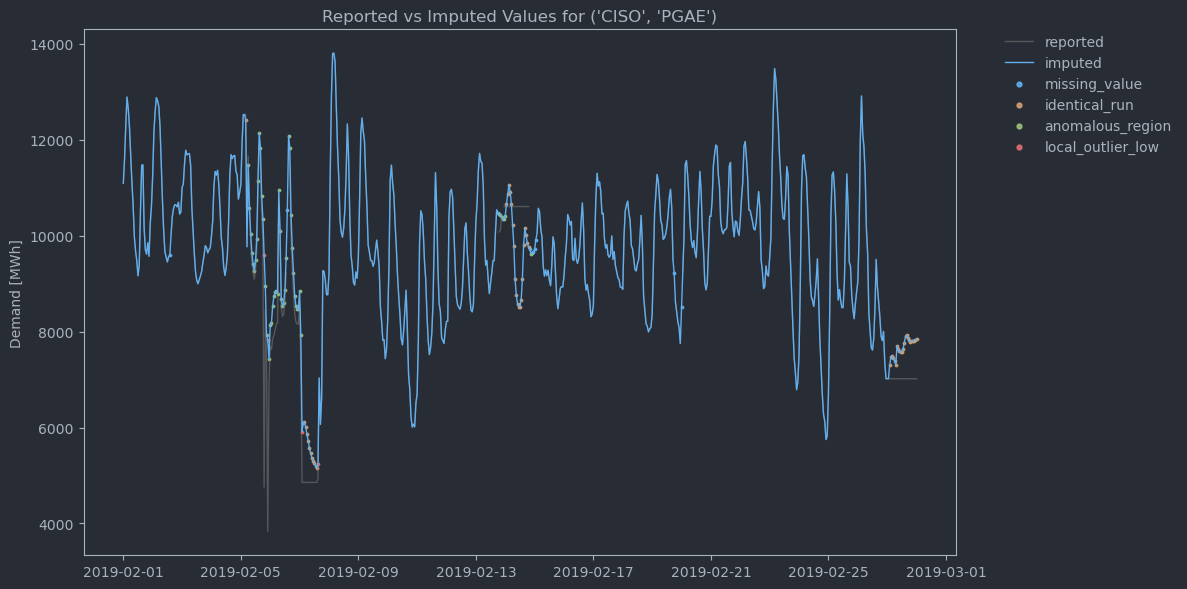

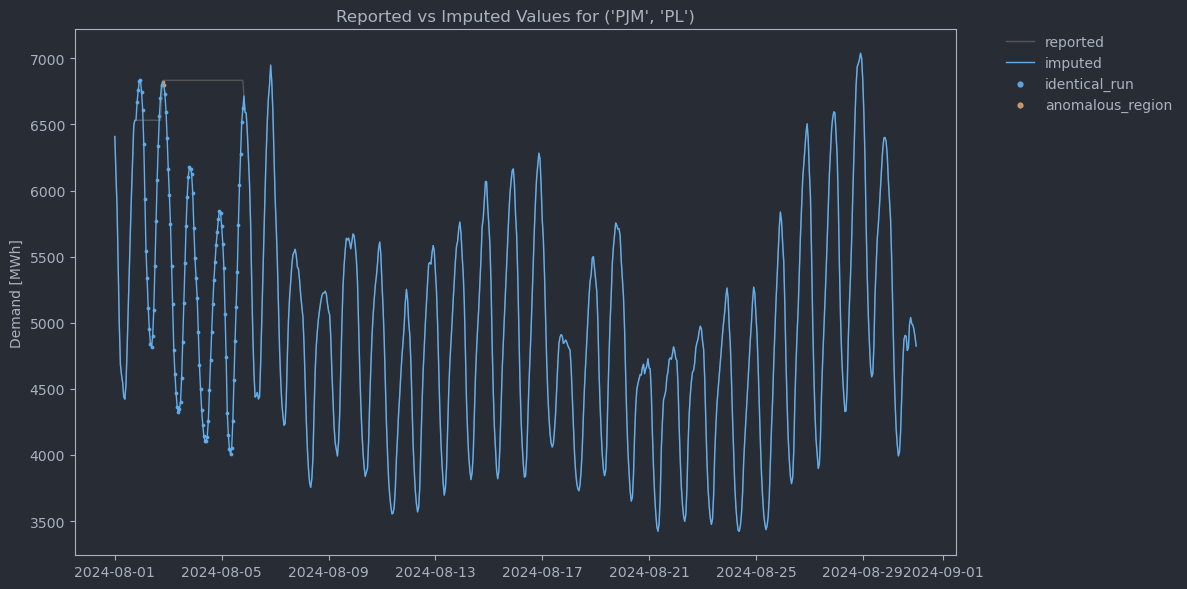

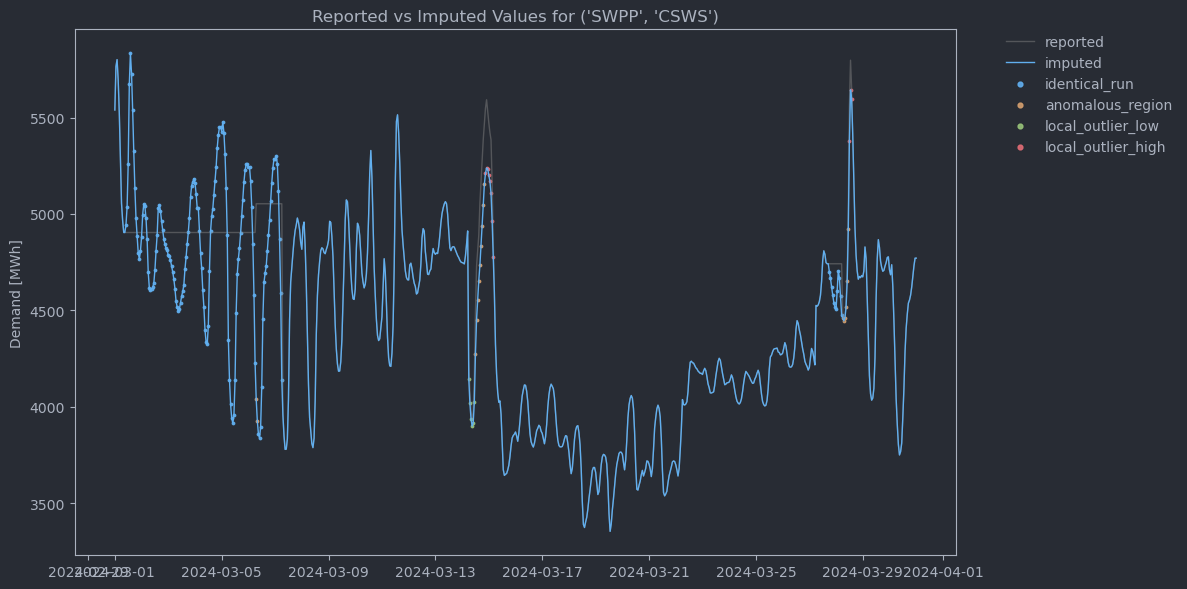

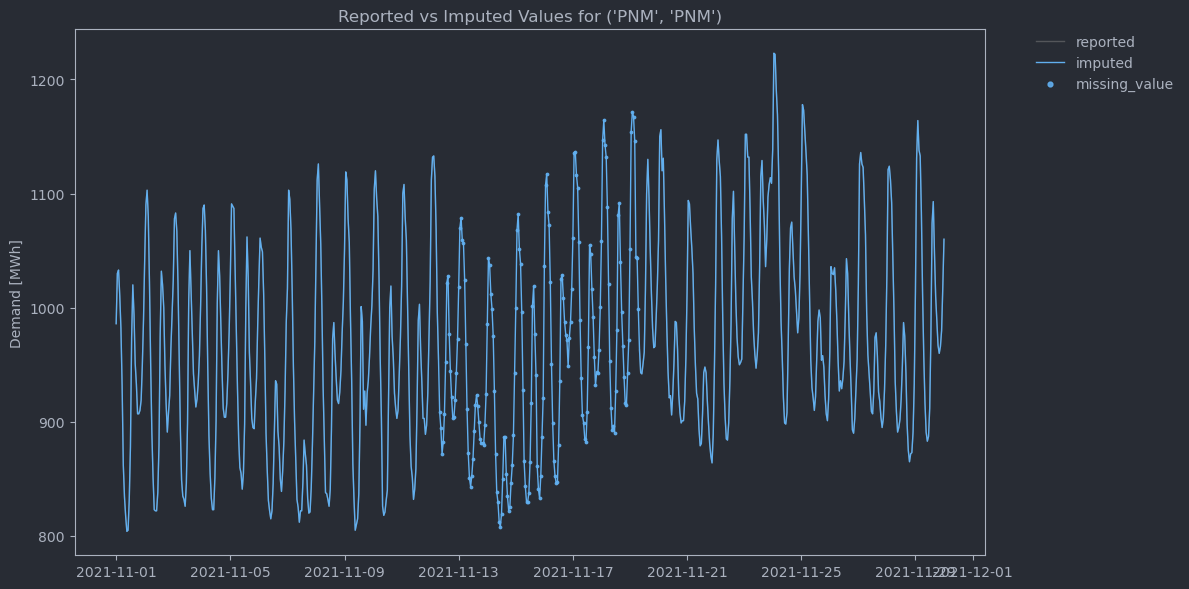

In [9]:
for month, subregion_idx_vals in [
    ("2019-02-01", ("CISO", "PGAE")),
    ("2024-08-01", ("PJM", "PL")),
    ("2024-03-01", ("SWPP", "CSWS")),
    ("2021-11-01", ("PNM", "PNM")),
]:
    plot_imputation(
        eia930_subregion_demand,
        idx_cols=subregion_idx_cols,
        idx_vals=subregion_idx_vals,
        start_date=month,
        end_date=pd.Timestamp(month) + MonthEnd(),
        reported_col="demand_reported_mwh",
        imputed_col="demand_imputed_pudl_mwh",
    )

#### Results
In the above plots, we see several common patterns that lead to imputation. Below we'll briefly go into each of the flagged sections we see here.

- **Missing Data -**
The final plot has a large section of missing data in the middle, while the first plot has a few small collections of missing values.

- **Identical Runs -**
We define identical runs as sections of data with the exact same value for multiple hours in a row. The exact number of consecutive values required to qualify as an identical run is configurable, but we use 3. Identical regions occur in the first three plots. These range from relatively short sections like we see in the first plot, to multi-day sections, which we can see in the second and third.

- **Local Outliers -**
We flag both local and global outliers. To identify global outliers we compare values to the global median for the corresponding entity, while for local outliers compare values to a rolling median. In these plots, we only see local outliers, which appear in the first and third plots.


- **Anomalous Region -**
Anomalous regions occur when we see a section of data that is surrounded by flagged values. Values which are flagged as a part of an anomalous region do not otherwise meet the criteria to be flagged, but their proximity to other "bad" data gives us less confidence in their accuracy. In general, we don't see anomalous regions very often, but when we're focusing on data with a high rate of imputation, we're much more likely to see these regions, and in these plots they exist in all but the last one.

Applying the "Eye Test" to these plots, we find the imputed data to look generally reasonable. The curves are not obviously out of line with the surrounding "good" sections of data. Later, we'll compare these same sections of data to the baseline imputed data described above.

### EIA 930 BA Demand
Now we will repeat this process with EIA 930 BA demand.

#### Months of Interest

In [10]:
# Load imputed subregion demand table from nightly builds
eia930_ba_demand = get_s3_nightly("out_eia930__hourly_operations")

# Find months with a high rate of imputation
ba_idx_cols = ["balancing_authority_code_eia"]
ba_months_of_interest = get_imputation_rate(eia930_ba_demand, idx_cols=ba_idx_cols, num_samples=0)
ba_months_of_interest.head(15)

balancing_authority_code_eia      month  imputation_rate
2939                         PACE 2016-09-01         0.244444
3650                         PSEI 2018-12-01         0.237903
4097                         SOCO 2018-03-01         0.228495
3052                         PACW 2016-08-01         0.227151
4085                         SOCO 2017-03-01         0.223118
3055                         PACW 2016-11-01         0.220833
4210                          SRP 2018-02-01         0.214286
4081                         SOCO 2016-11-01         0.209722
2274                         LDWP 2018-04-01         0.205556
4366                         SWPP 2021-08-01         0.197581
4345                         SWPP 2019-11-01         0.194444
2938                         PACE 2016-08-01         0.190860
1635                          FPL 2022-01-01         0.186828
3045                         PACW 2016-01-01         0.185484
661                          CISO 2016-11-01         0.181944

#### Plots
Given that there's already a good mix of BA's in the identified months, we'll just plot the top four.

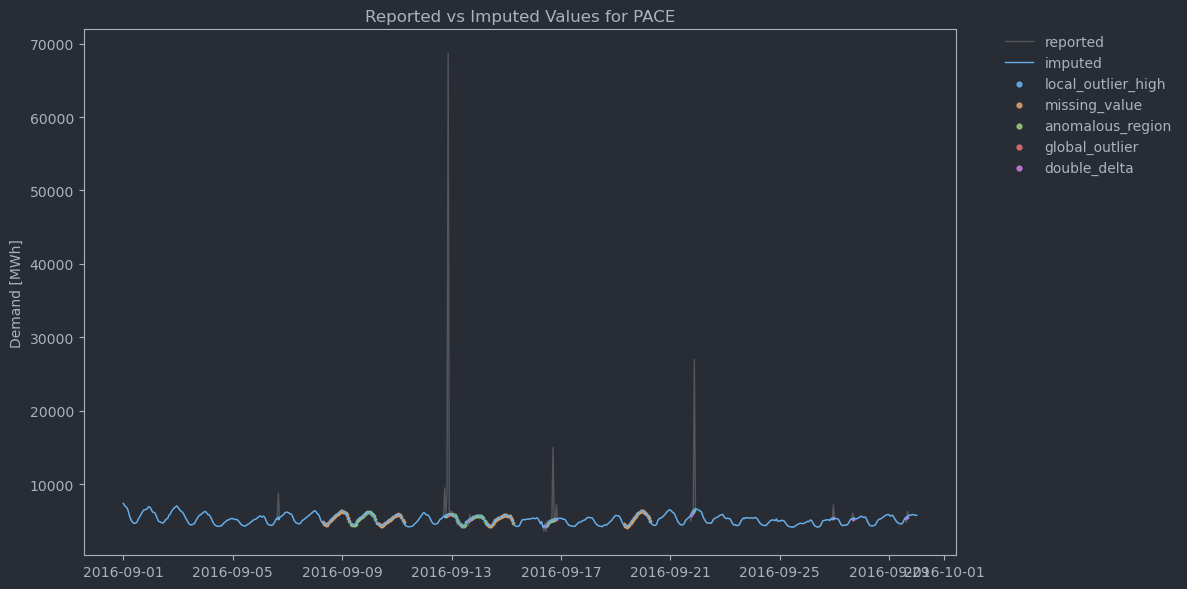

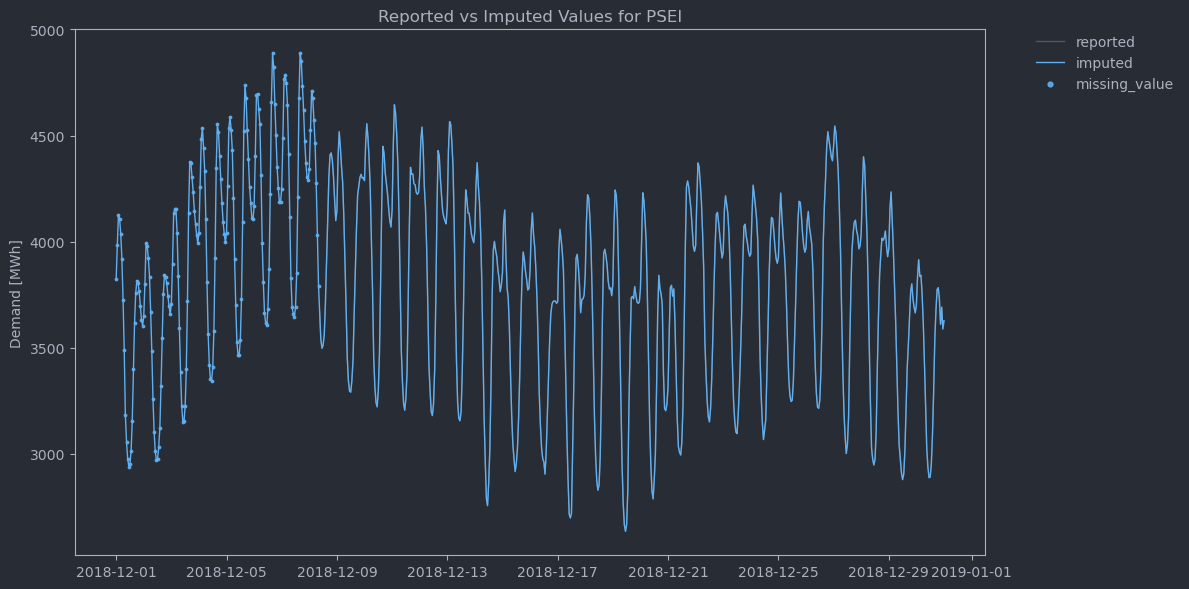

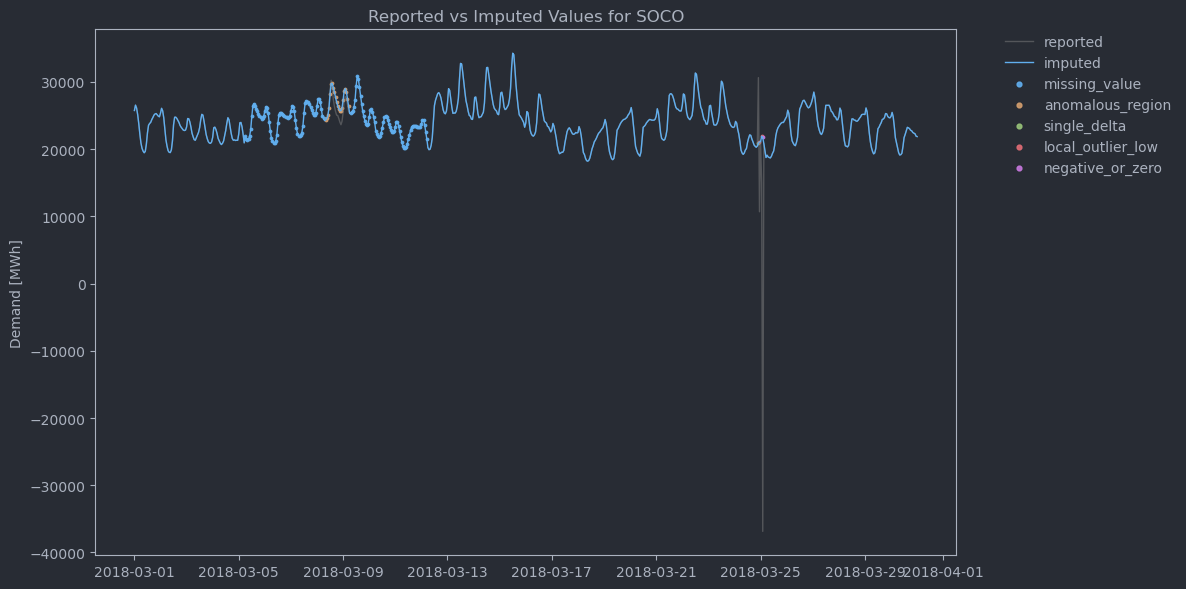

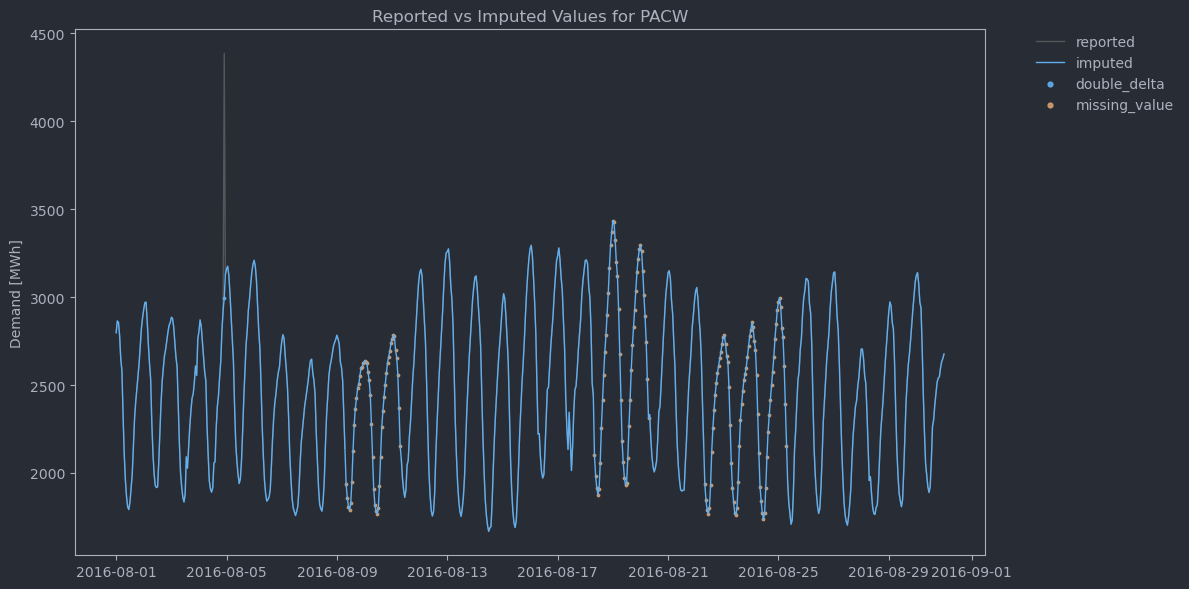

In [11]:
for month, ba_idx_vals in [
    ("2016-09-01", ("PACE")),
    ("2018-12-01", ("PSEI")),
    ("2018-03-01", ("SOCO")),
    ("2016-08-01", ("PACW")),
]:
    plot_imputation(
        eia930_ba_demand,
        idx_cols=ba_idx_cols,
        idx_vals=ba_idx_vals,
        start_date=month,
        end_date=pd.Timestamp(month) + MonthEnd(),
        reported_col="demand_reported_mwh",
        imputed_col="demand_imputed_pudl_mwh",
    )

#### Results

- **Missing Data -**
Again, we see several sections of missing data in these plots. In fact, we see at least some missing data in every single plot. 


- **Local/Global Outliers -**
In these plots we see both local and global outliers. Local outliers occur in both the first and third plots, while global outliers are only found in the third plot.

- **Double/Single Delta -**
Values flagged as double or single delta are identified by comparing values to their neighbors. This is done by computing a sliding Inter Quantile Range, and finding values which are more than 1 or 2 times this range from their nearest neighbor. These can be seen in all but the second plot.

- **Negative or Zero -**
Values which are negative or zero also get flagged, which can be seen in the third plot.

Again, we don't see any paritcularly concerning results in these plots. The imputed curves all look to be generally in-line with the surrounding reported data. These plots also provide a great demonstration of how the imputation can smooth out significant outliers, which occur in several of these examples.

## Compare to Baseline Imputation
Next, we'll demonstrate how we used the baseline imputation referenced above to compare with our implementation. While our implementation is adapted from this reference, we've use a different underlying method for the actual imputation, so we don't expect our results to be exactly the same. Instead, we want to check that our results are not obviously worse, and that there are not any significant systemic differences between our results.

### Prepare Reference Data for Comparison
The reference data is published on zenodo [here](https://zenodo.org/records/14768167). Below we'll define a function that will load this data into a pandas DataFrame, then transform it to a structure equivalent to our own data.

In [12]:
def extract_baseline_imputation() -> pd.DataFrame:
    r = requests.get("https://zenodo.org/records/14768167/files/truggles/EIA_Cleaned_Hourly_Electricity_Demand_Data-v1.4.zip?download=1")
    f = BytesIO(r.content)
    subregions = []
    aggregations = []
    base_path = "truggles-EIA_Cleaned_Hourly_Electricity_Demand_Data-5c959df/data/"
    archive = zipfile.Path(f, at=base_path)
    for release in ["release_2020_Oct_include_subregions", "release_2025_Jan_include_subregions"]:
        # Get subregion data
        for path in (archive / release / "subregions_and_balancing_authorities").iterdir():
            if not path.name.endswith(".csv"):
                continue
            df = pd.read_csv(path.open())

            # Get subregion/ba
            stem = path.name.split(".")[0]
            name = stem.split("-")
            ba = name[0]
            subregion = None if len(name) == 1 else name[1]
            df["balancing_authority_code_eia"] = ba
            df["balancing_authority_subregion_code_eia"] = subregion

            subregions.append(df)

        # Get aggregated data
        if "2025" in release:
            for agg_level, agg_level_path in {
                "conus": "contiguous_US",
                "interconnect": "interconnects",
                "region": "regions",
            }.items():
                for path in (archive / release / agg_level_path).iterdir():
                    if not path.name.endswith(".csv"):
                        continue

                    df = pd.read_csv(path.open())
                    df["aggregation_level"] = agg_level
                    if agg_level == "conus":
                        df["aggregation_group"] = "conus"
                    elif agg_level == "interconnect":
                        group = path.name.split("_")[0].lower()
                        group = "ercot" if group == "texas" else group
                        df["aggregation_group"] = group
                    elif agg_level == "region":
                        df["aggregation_group"] = path.name.split(".")[0].lower()
                    aggregations.append(df)

    subregions_df = pd.concat(subregions).rename(columns={"cleaned demand (MW)": "baseline_demand_mwh"}).reset_index()
    subregions_df["datetime_utc"] = pd.to_datetime(subregions_df["date_time"])

    aggregated_df = pd.concat(aggregations).rename(
        columns={"cleaned demand (MW)": "baseline_demand_mwh", "raw demand (MW)": "raw_demand_mwh"}
    ).reset_index()
    aggregated_df["datetime_utc"] = pd.to_datetime(aggregated_df["date_time"])

    return (
        subregions_df[["datetime_utc", "baseline_demand_mwh", "balancing_authority_code_eia", "balancing_authority_subregion_code_eia"]],
        aggregated_df[["datetime_utc", "baseline_demand_mwh", "raw_demand_mwh", "aggregation_level", "aggregation_group"]]
    )

baseline_subregion_demand, baseline_aggregated_demand = extract_baseline_imputation()

### Merge PUDL Data with Baseline
Below, we'll merge the PUDL BA and subregion demand with the baseline version for comparison.

In [13]:
subregion_comparison_df = eia930_subregion_demand.merge(
    baseline_subregion_demand,
    on=["datetime_utc", "balancing_authority_code_eia", "balancing_authority_subregion_code_eia"],
    how="inner"
)

ba_comparison_df = eia930_ba_demand.merge(
    baseline_subregion_demand[baseline_subregion_demand["balancing_authority_subregion_code_eia"].isnull()],
    on=["datetime_utc", "balancing_authority_code_eia"],
    how="inner"
)

### Implement function to visualize both imputation versions
Now, we'll define a function to create plots similar to those above, but which include the baseline imputed data. We'll also use some of the regions identified above during these comparisons.

In [14]:
def plot_compare_imputation(
    df: pd.DataFrame,
    idx_cols: list[str],
    idx_vals: tuple[Any],
    start_date: str,
    end_date: str,
    reported_col: str,
    timeseries_a: str,
    timeseries_b: str,
    time_col: str = "datetime_utc",
    ylabel: str = "Demand [MWh]",
):  # pragma: no cover
    """Plot two timeseries of the same information like demand for comparison."""
    filtered = _filter_df(df, idx_cols, idx_vals, start_date, end_date, time_col)

    # Plot reported
    plt.figure(figsize=(12, 6))
    plt.plot(
        filtered.index,
        filtered[reported_col],
        lw=1,
        color="gray",
        label="reported",
        alpha=0.5,
    )

    plt.plot(filtered.index, filtered[timeseries_a], lw=1, label=timeseries_a)
    plt.plot(filtered.index, filtered[timeseries_b], lw=1, label=timeseries_b, ls="--")
    plt.title(f"{timeseries_a} vs {timeseries_b} for {idx_vals}")
    plt.ylabel(ylabel)
    plt.legend(
        bbox_to_anchor=(1.05, 1),
        loc="upper left",
        borderaxespad=0.0,
    )
    plt.tight_layout()  # Adjust layout to make room for the legend
    plt.show()

### EIA 930 Subregion Demand Comparison

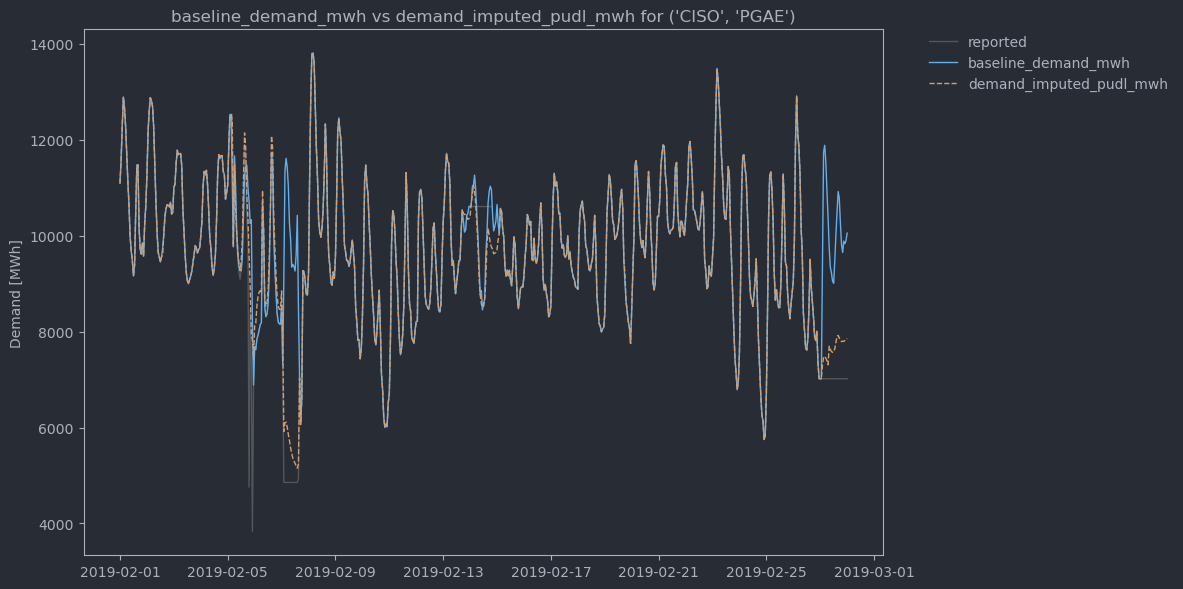

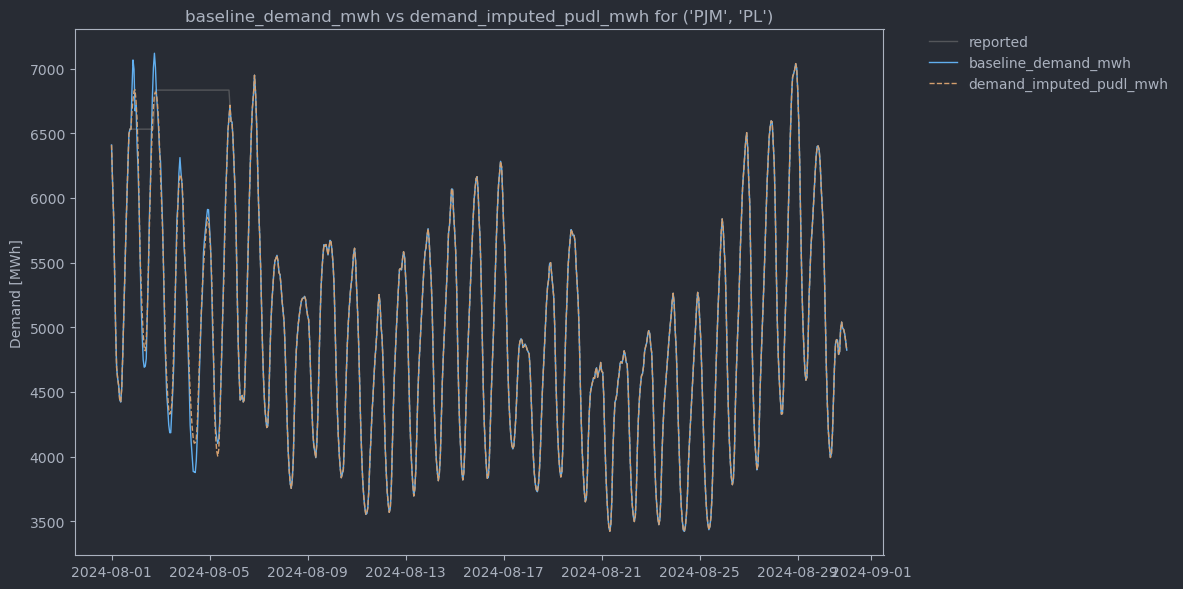

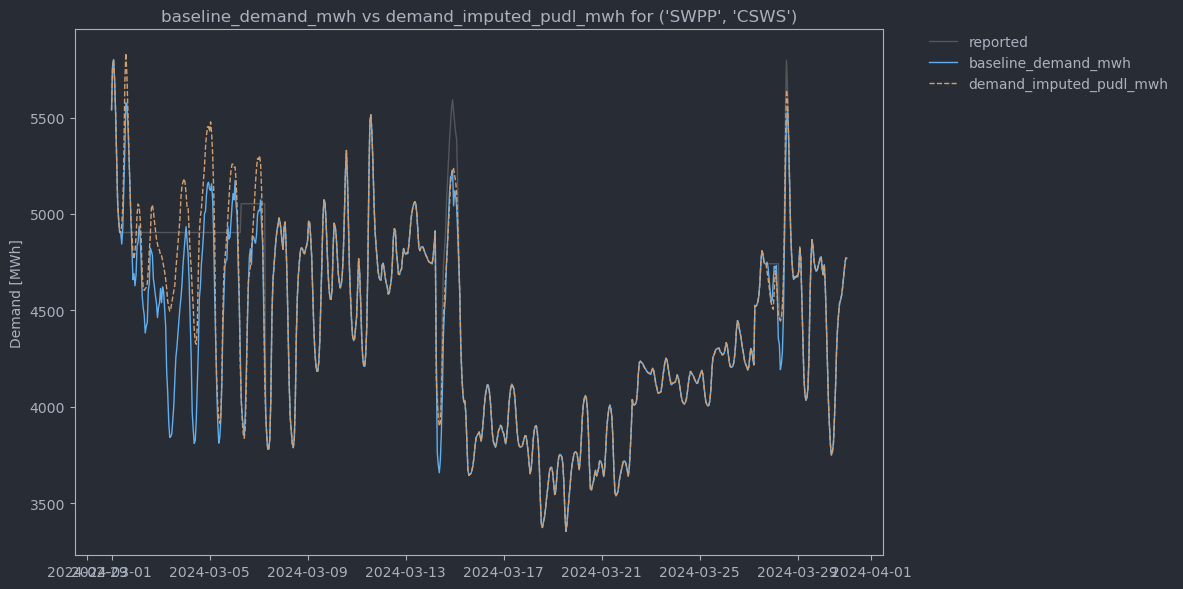

In [15]:
for month, subregion_idx_vals in [
    ("2019-02-01", ("CISO", "PGAE")),
    ("2024-08-01", ("PJM", "PL")),
    ("2024-03-01", ("SWPP", "CSWS")),
]:
    plot_compare_imputation(
        subregion_comparison_df,
        idx_cols=subregion_idx_cols,
        idx_vals=subregion_idx_vals,
        start_date=month,
        end_date=pd.Timestamp(month) + MonthEnd(),
        timeseries_a="baseline_demand_mwh",
        timeseries_b="demand_imputed_pudl_mwh",
        reported_col="demand_reported_mwh",
    )

Here we see that there are certainly differences in our results, but there is not any reason to immediately assume our results are worse than the reference, which for our purposes is all we're really looking for. Below, we'll take this line of investigation a step further to ensure that across the board there aren't any significant sytemic differences between our results.

### EIA 930 BA Demand Comparison

The baseline imputation doesn't have as much coverage as the PUDL version, so we can't use the exact same sections as above. Instead, we've chosen several sections where know there is overlap.

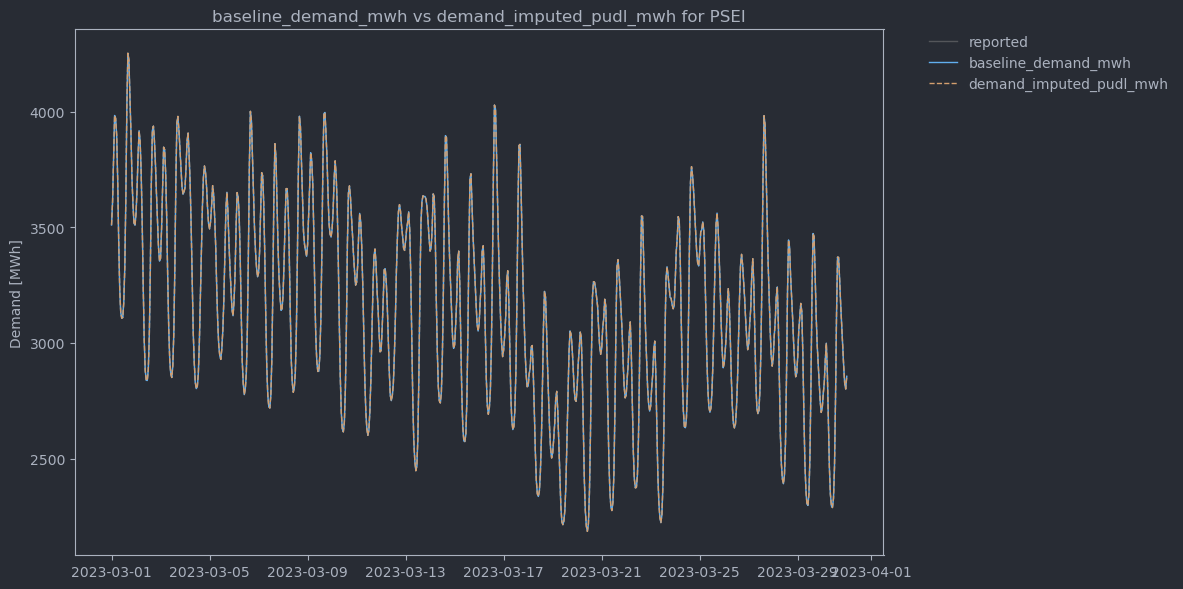

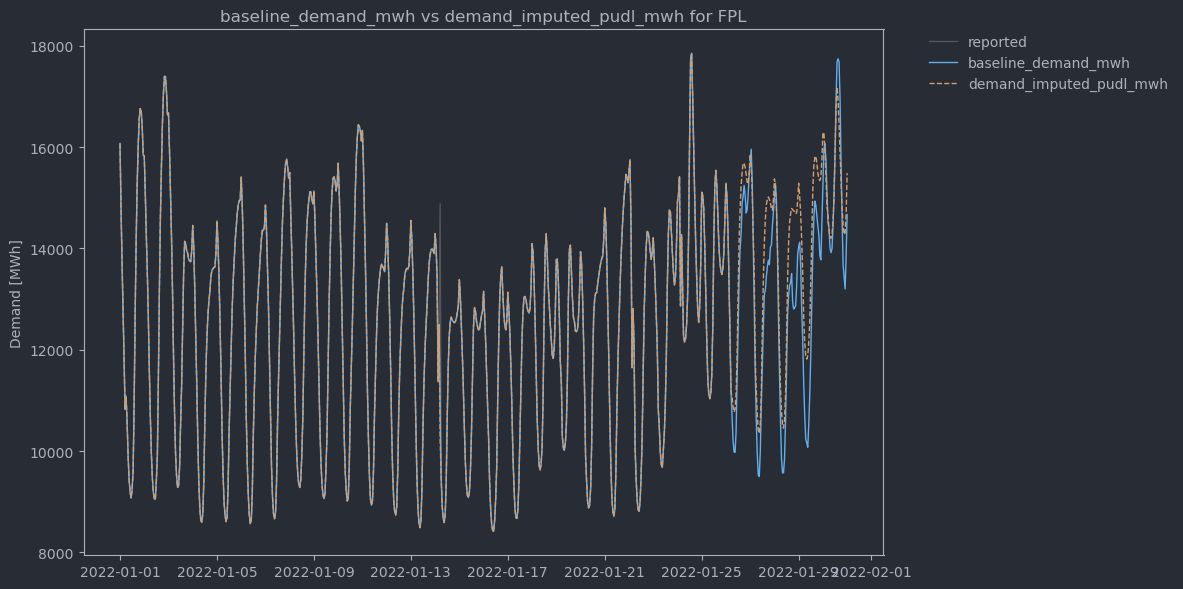

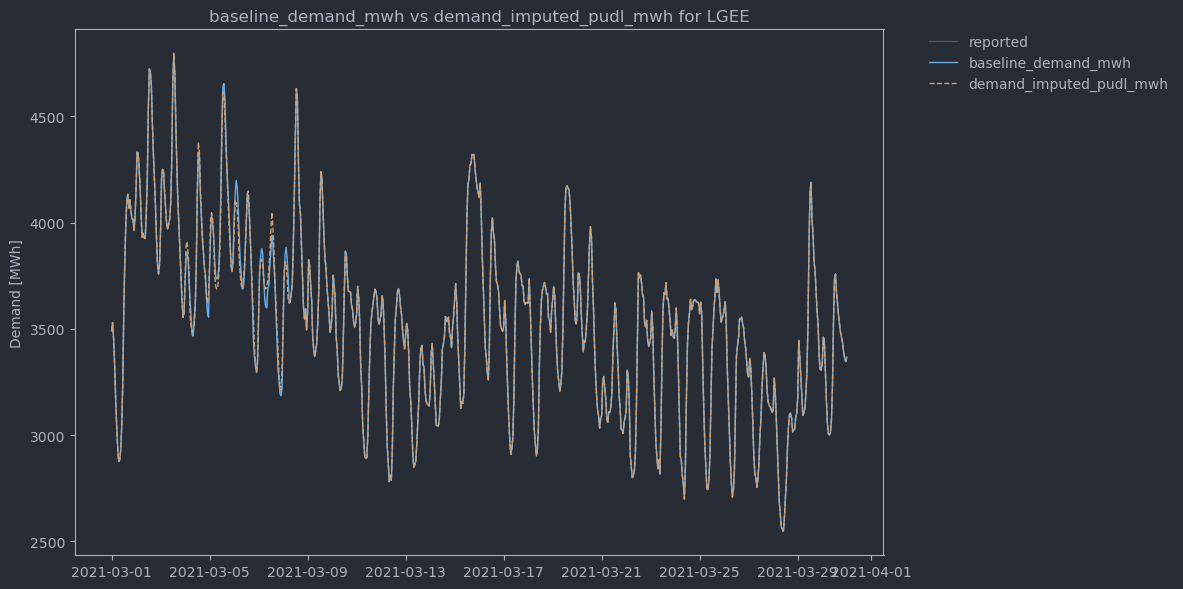

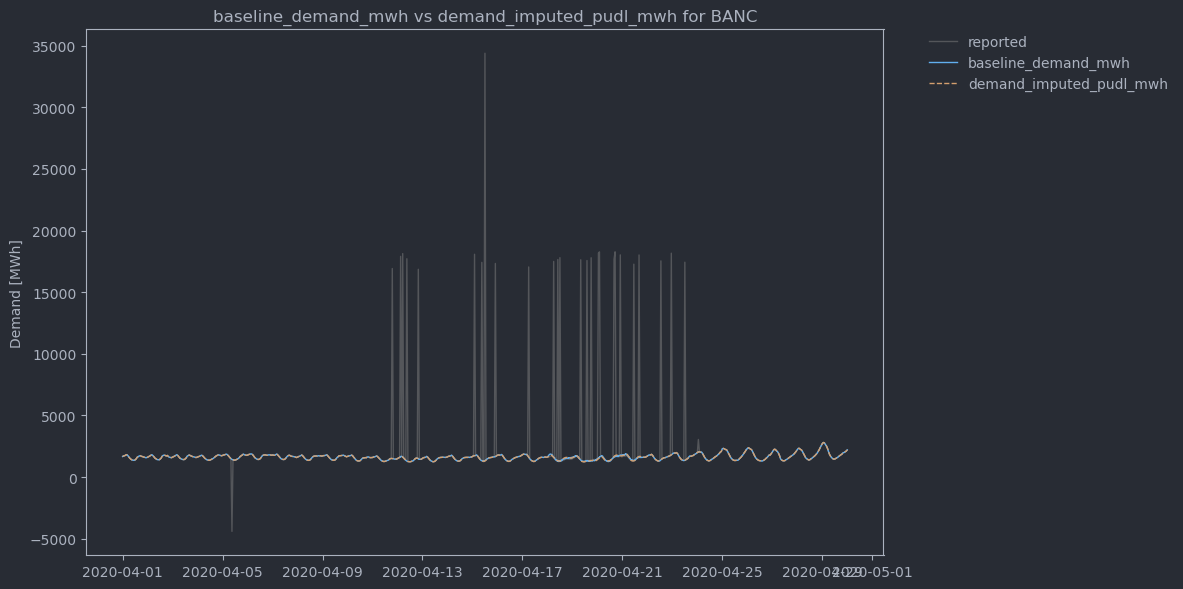

In [16]:
for month, ba_idx_vals in [
    ("2023-03-01", ("PSEI")),
    ("2022-01-01", ("FPL")),
    ("2021-03-01", ("LGEE")),
    ("2020-04-01", ("BANC")),
]:
    plot_compare_imputation(
        ba_comparison_df,
        idx_cols=ba_idx_cols,
        idx_vals=ba_idx_vals,
        start_date=month,
        end_date=pd.Timestamp(month) + MonthEnd(),
        timeseries_a="baseline_demand_mwh",
        timeseries_b="demand_imputed_pudl_mwh",
        reported_col="demand_reported_mwh",
    )

## Look for Systemic Differences
While we expect there to be variation between our two imputations, it may be concerning if one implementation was consistently imputing larger or smaller values. To look for this type of systemic difference, we can compare the correlation between our imputations. 

In [17]:
import matplotlib.cm as cm
import matplotlib.colors as mcolors

def plot_correlation(
    df: pd.DataFrame,
    timeseries_x: str,
    timeseries_y: str,
    idx_cols: list[str],
    idx_vals: list[tuple[Any] | str] | None = None,
    xylim: tuple[float] | None = None,
    xlabel: str = "",
    ylabel: str = "",
    title: str = "",
    time_col: str = "datetime_utc",
    start_date: str | None = None,
    end_date: str | None = None,
    log: bool = True,
    legend: bool = True,
    alpha: float = 0.1,
):
    """Plot the correlation between two analogous time series."""
    plt.figure(figsize=(12, 12))

    # Generate a color palette using Matplotlib
    # Use the "tab10" colormap with the required number of colors
    cmap = cm.get_cmap("tab10", len(idx_vals))
    # Convert colors to hex format
    palette = [mcolors.to_hex(cmap(i)) for i in range(len(idx_vals))]
    color_map = {group: palette[i] for i, group in enumerate(idx_vals)}

    for idx in idx_vals:
        filtered = _filter_df(
            df,
            idx_cols=idx_cols,
            idx_vals=idx,
            start_date=start_date,
            end_date=end_date,
            time_col=time_col,
        )
        label = "-".join(str(idx)) if isinstance(idx, tuple) else str(idx)
        plt.scatter(
            filtered[timeseries_x],
            filtered[timeseries_y],
            s=0.1,
            alpha=alpha,
            label=label,
            color=color_map[idx],
        )

    if xylim is not None:
        plt.xlim(xylim)
        plt.ylim(xylim)
    if log:
        plt.xscale("log")
        plt.yscale("log")

    # Add some gridlines
    plt.grid(True, which="both", ls="--", lw=0.5, alpha=0.5)
    # Show line for perfect correlation where x == y
    xlim = plt.gca().get_xlim()
    ylim = plt.gca().get_ylim()
    min_val = max(min(xlim), min(ylim))
    max_val = min(max(xlim), max(ylim))
    plt.plot(
        [min_val, max_val],
        [min_val, max_val],
        linestyle="--",
        color="gray",
        linewidth=0.5,
    )

    if legend:
        leg = plt.legend(
            loc="upper left",
            scatterpoints=3,
            markerscale=10,
            labelspacing=1.2,
        )
        for lh in leg.legend_handles:
            lh.set_alpha(1.0)

    # Label the plot
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)

    plt.tight_layout()
    plt.show()


### Plot Subregion Correlation

/tmp/ipykernel_5819/1230349378.py:26: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("tab10", len(idx_vals))


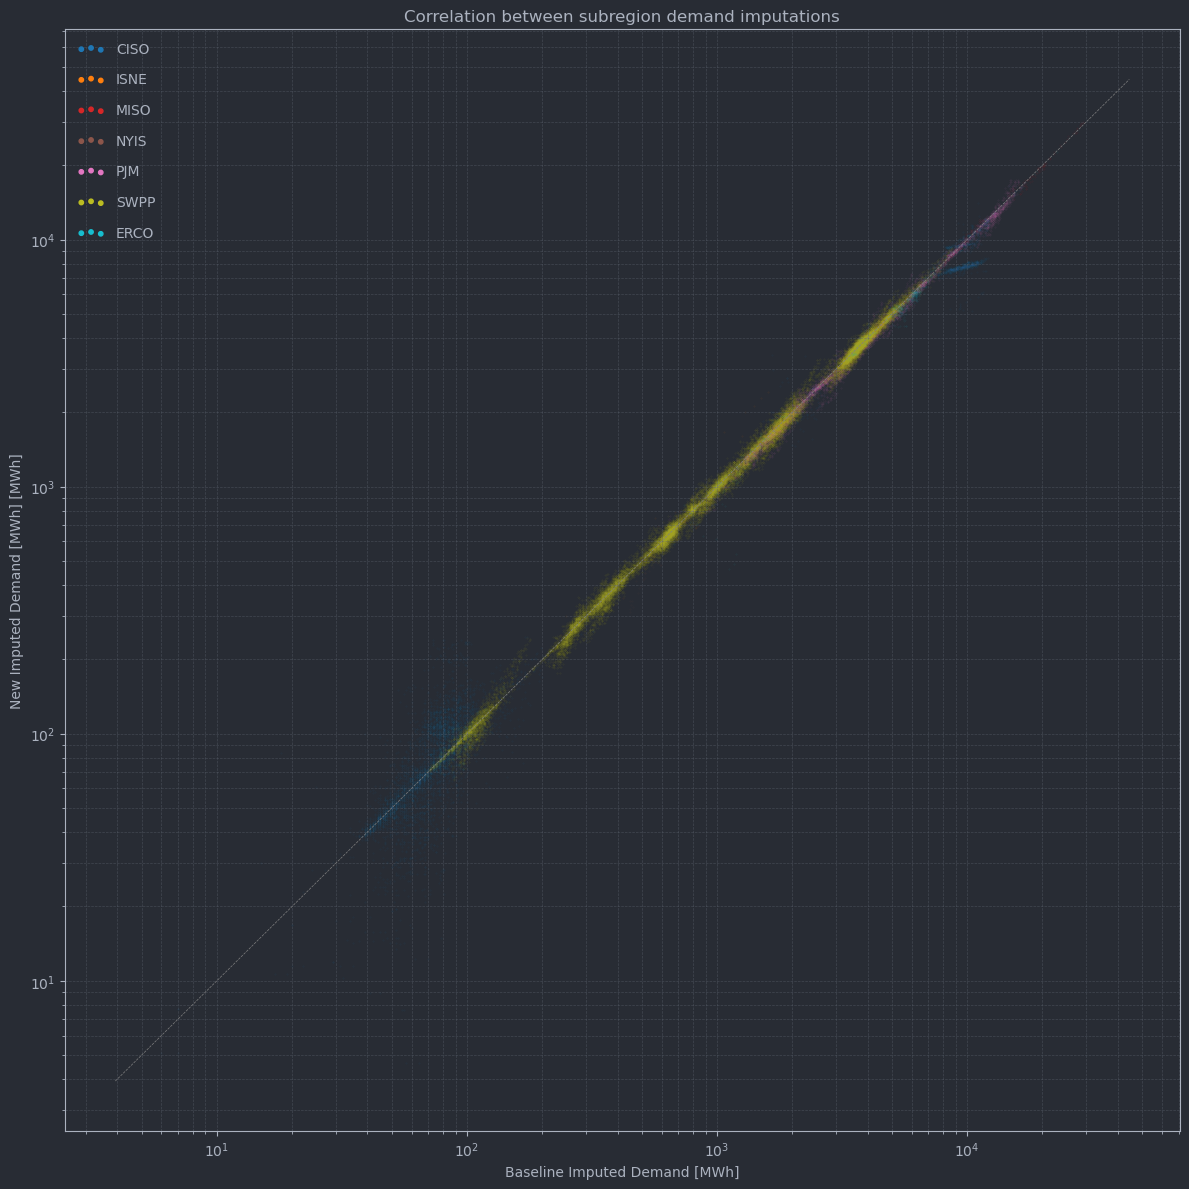

In [18]:
all_bas = list(subregion_comparison_df["balancing_authority_code_eia"].unique())

plot_correlation(
    subregion_comparison_df[subregion_comparison_df.demand_imputed_pudl_mwh_imputation_code.notnull()].reset_index(),
    idx_cols=["balancing_authority_code_eia"],
    idx_vals=all_bas,
    timeseries_x="baseline_demand_mwh",
    timeseries_y="demand_imputed_pudl_mwh",
    xlabel="Baseline Imputed Demand [MWh]",
    ylabel="New Imputed Demand [MWh] [MWh]",
    title="Correlation between subregion demand imputations",
    alpha=0.1,
)

In this plot, each point represents a single imputed value with the baseline imputation on the X-axis, and our new imputation on the Y-axis. We expect to see the points generally follow the dotted line if there is a degree of correlation. Overall this appears to be generally, and while there is variation, there's not any obvious signs of a systemic bias. That being said, we can take a closer look at some of the BA's which show more variation in the imputation so get a better sense for what's going on here.

#### Investigate CISO

/tmp/ipykernel_5819/1230349378.py:26: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("tab10", len(idx_vals))


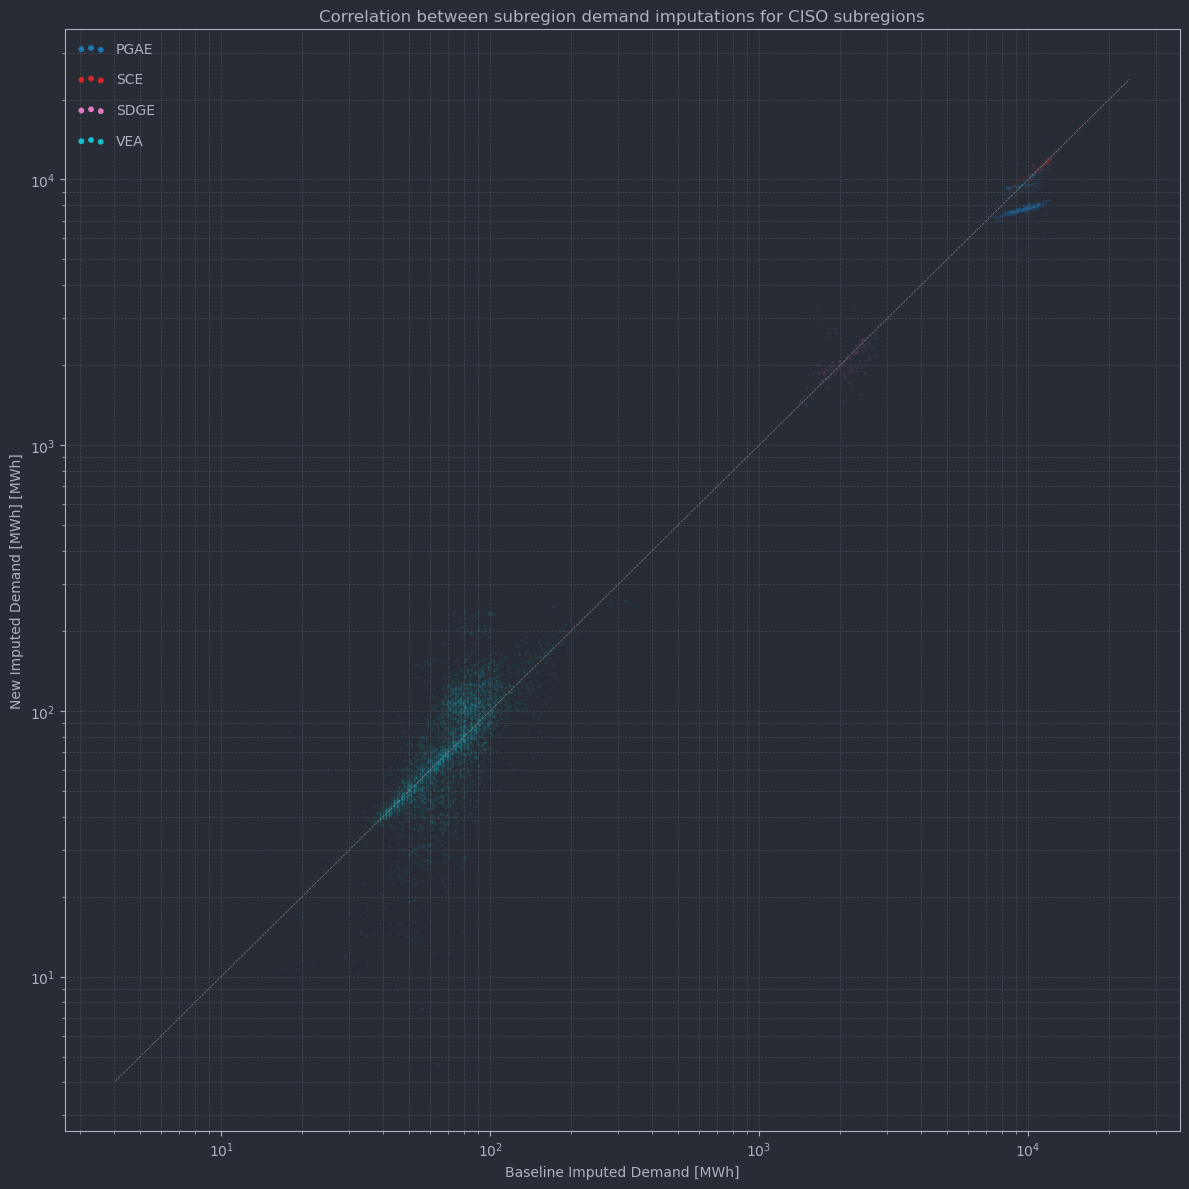

In [19]:
ba = "CISO"
selection = subregion_comparison_df[subregion_comparison_df["balancing_authority_code_eia"] == ba]
all_subregions = list(selection["balancing_authority_subregion_code_eia"].unique())

plot_correlation(
    selection[selection.demand_imputed_pudl_mwh_imputation_code.notnull()].reset_index(),
    idx_cols=["balancing_authority_subregion_code_eia"],
    idx_vals=all_subregions,
    timeseries_x="baseline_demand_mwh",
    timeseries_y="demand_imputed_pudl_mwh",
    xlabel="Baseline Imputed Demand [MWh]",
    ylabel="New Imputed Demand [MWh] [MWh]",
    title="Correlation between subregion demand imputations for CISO subregions",
    alpha=0.2,
)

Looking at this plot, there's a couple portions of data which stand out as potentially interesting. First, there seems to be a high degree of variation in the VEA data, which, while it doesn't indicate a systemic bias, it is out of line with the other subregions. The other area of interest is PGAE, which has a segment consistently below the correlation line, which could be indicative of something more systemic.

To investigate these sections, let's look at the relative imputation rates across all CISO subregions to see if there's anything unique going on with these subregions. To do this, we'll use the `get_imputation_rate` function, but this time we won't limit the range on the imputation rate, and we'll use `time_period="year"` to see imputation rate by year.

In [20]:
ciso_imputation_rate = get_imputation_rate(
    eia930_subregion_demand,
    idx_cols=subregion_idx_cols,
    num_samples=0,
    min_imputation_rate=0.0,
    max_imputation_rate=1.0,
    time_period="year"
)
ciso_imputation_rate[
    ciso_imputation_rate.balancing_authority_code_eia == "CISO"
].sort_values(by="imputation_rate", ascending=False)

/tmp/ipykernel_5819/4070514050.py:29: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  median_entity_demand = df.groupby(by=idx_cols)[imputed_col].median()


balancing_authority_code_eia balancing_authority_subregion_code_eia  \
0                          CISO                                   PGAE   
12                         CISO                                   SDGE   
6                          CISO                                    SCE   
11                         CISO                                    SCE   
5                          CISO                                   PGAE   
17                         CISO                                   SDGE   
14                         CISO                                   SDGE   
13                         CISO                                   SDGE   
2                          CISO                                   PGAE   
8                          CISO                                    SCE   
7                          CISO                                    SCE   
1                          CISO                                   PGAE   
9                          CISO                                    SCE   
15                         CISO                                   SDGE   
3                          CISO                                   PGAE   
16                         CISO                                   SDGE   
10                         CISO                                    SCE   
4                          CISO                                   PGAE   

         year  imputation_rate  
0  2019-12-31         0.079534  
12 2019-12-31         0.007199  
6  2019-12-31         0.007085  
11 2024-12-31         0.005578  
5  2024-12-31         0.005464  
17 2024-12-31         0.005464  
14 2021-12-31         0.000913  
13 2020-12-31         0.000797  
2  2021-12-31         0.000685  
8  2021-12-31         0.000571  
7  2020-12-31         0.000455  
1  2020-12-31         0.000455  
9  2022-12-31         0.000342  
15 2022-12-31         0.000342  
3  2022-12-31         0.000342  
16 2023-12-31         0.000342  
10 2023-12-31         0.000228  
4  2023-12-31         0.000228

From these results, we see that VEA has the highest rates of imputation across the board other than a single year of PGAE data. It seems likely that the messiness VEA data is contributing to the higher levels of variation we're seeing. Another likely contributing factor is that VEA demand has a much lower magnitude, so on this log-plot similar levels of absolute variation will appear much more significant at these lower magnitudes.

Now looking at PGAE, we see that this data typically has quite low rates of imputation other than 2019. Given this, it seems likely the strange segment is coming from this year, so lets take a closer look. Below we'll plot a comparison of our imputation vs the baseline for PGAE 2019 data.

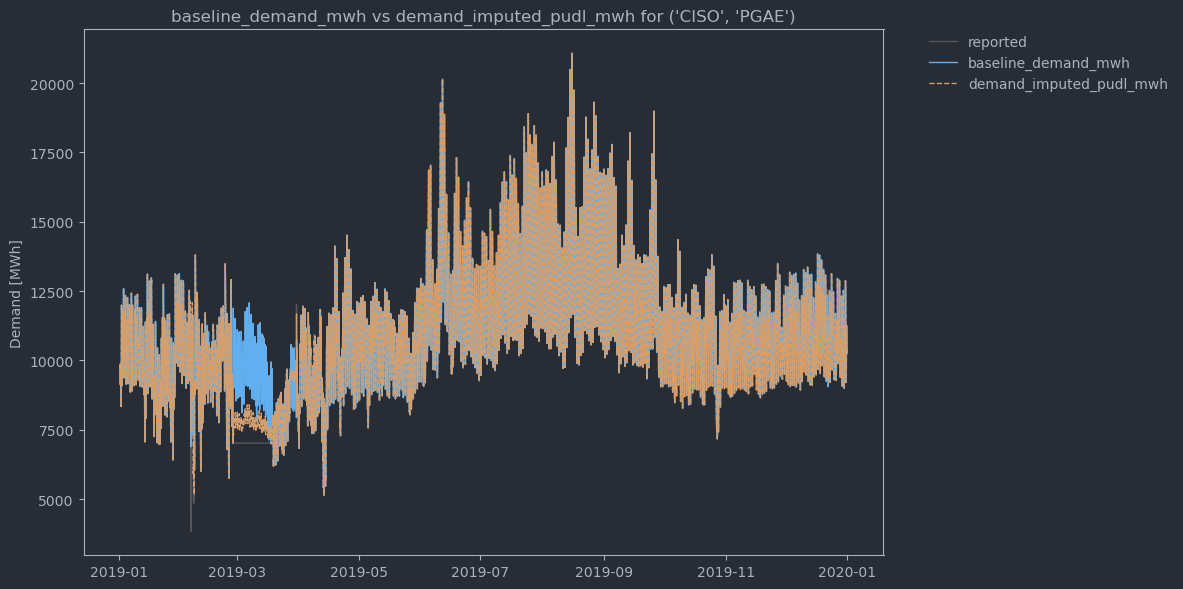

In [22]:
plot_compare_imputation(
    subregion_comparison_df,
    idx_cols=subregion_idx_cols,
    idx_vals=("CISO", "PGAE"),
    start_date="2019-01-01",
    end_date="2019-12-31",
    timeseries_a="baseline_demand_mwh",
    timeseries_b="demand_imputed_pudl_mwh",
    reported_col="demand_reported_mwh",
)

Plotting an entire year like this is difficult to interpret, but we can clearly see there's a section around March where there's some significant differences between our results. Let's zoom in on this section to get a better sense for what's going on.

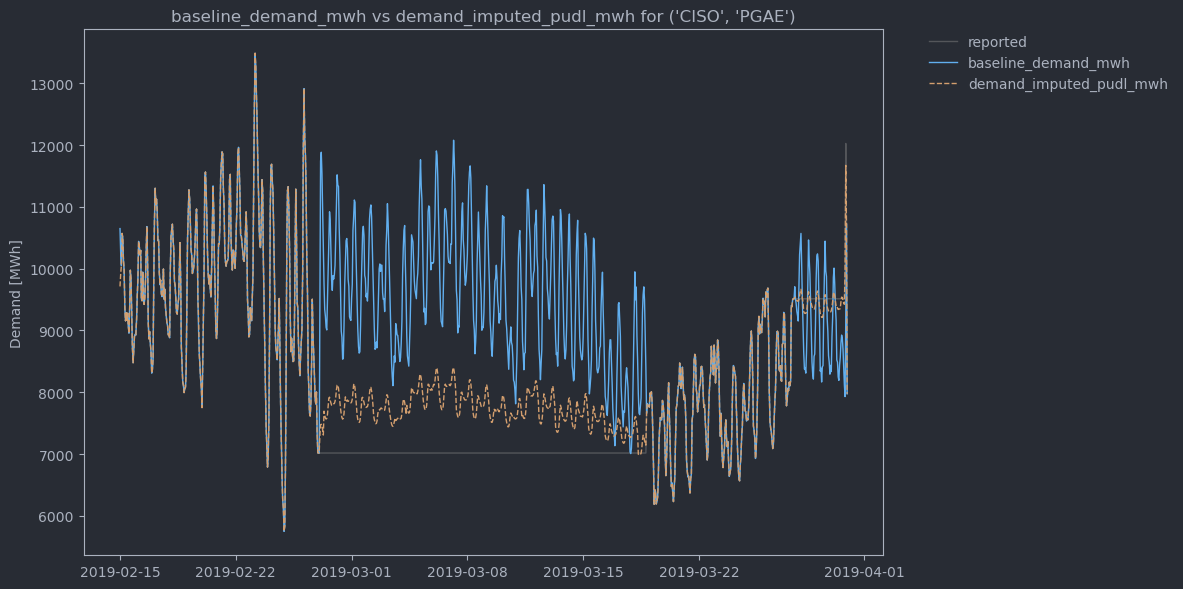

In [24]:
plot_compare_imputation(
    subregion_comparison_df,
    idx_cols=subregion_idx_cols,
    idx_vals=("CISO", "PGAE"),
    start_date="2019-02-15",
    end_date="2019-03-30",
    timeseries_a="baseline_demand_mwh",
    timeseries_b="demand_imputed_pudl_mwh",
    reported_col="demand_reported_mwh",
)

Here we see over half a month where all of the data is imputed, and our imputation is consistently lower than the baseline. This matches up quite closely with what we see in the correlation plot, and seems likely to explain it. This is probably the most concerning example of our imputation that we've seen. Clearly, the baseline imputation looks much more consistent with the reported data. It seems that something about the specific circumstances of this case have caused our imputation method to struggle. We're trying to identify the exact cause, and will update our method if we're able to do so. In the meantime we've also spent some time investigating for other similar cases, and so far have not identified any. If you use this data and discover any issues or concerns, please create an [issue](https://github.com/catalyst-cooperative/pudl/issues/) with details in the description.

Below, we will investigate for similar such cases, but first we will repeat this process with BA level data.

### Plot BA Correlation
Given the large number of BA's available, we'll only plot 10 BA's at a time to make the plots more digestible.

/tmp/ipykernel_5819/1230349378.py:26: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("tab10", len(idx_vals))


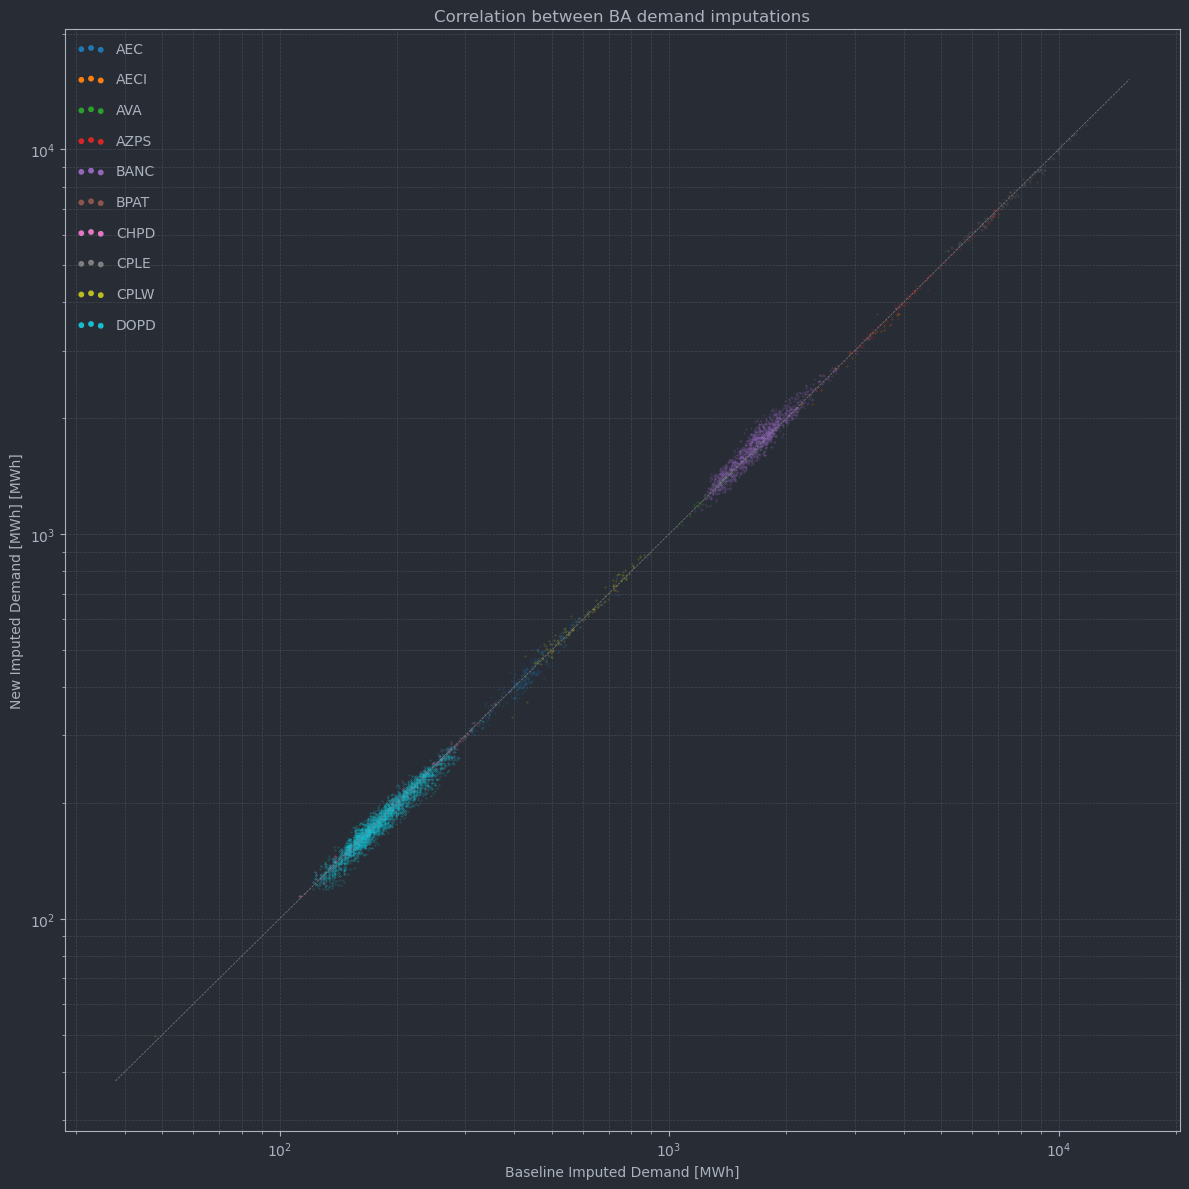

/tmp/ipykernel_5819/1230349378.py:26: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("tab10", len(idx_vals))


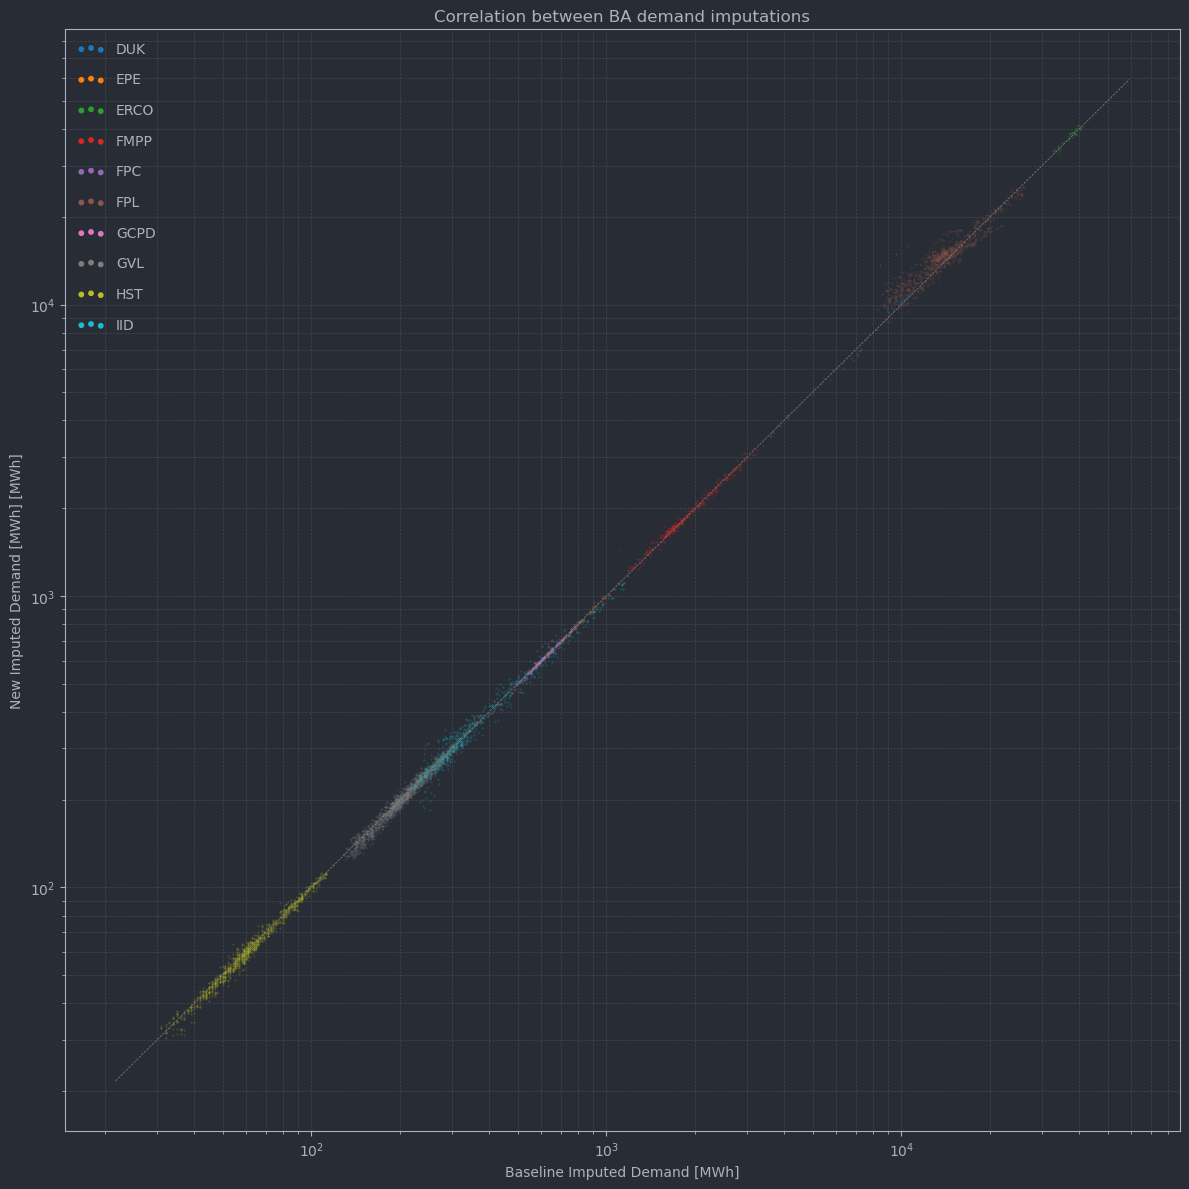

/tmp/ipykernel_5819/1230349378.py:26: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("tab10", len(idx_vals))


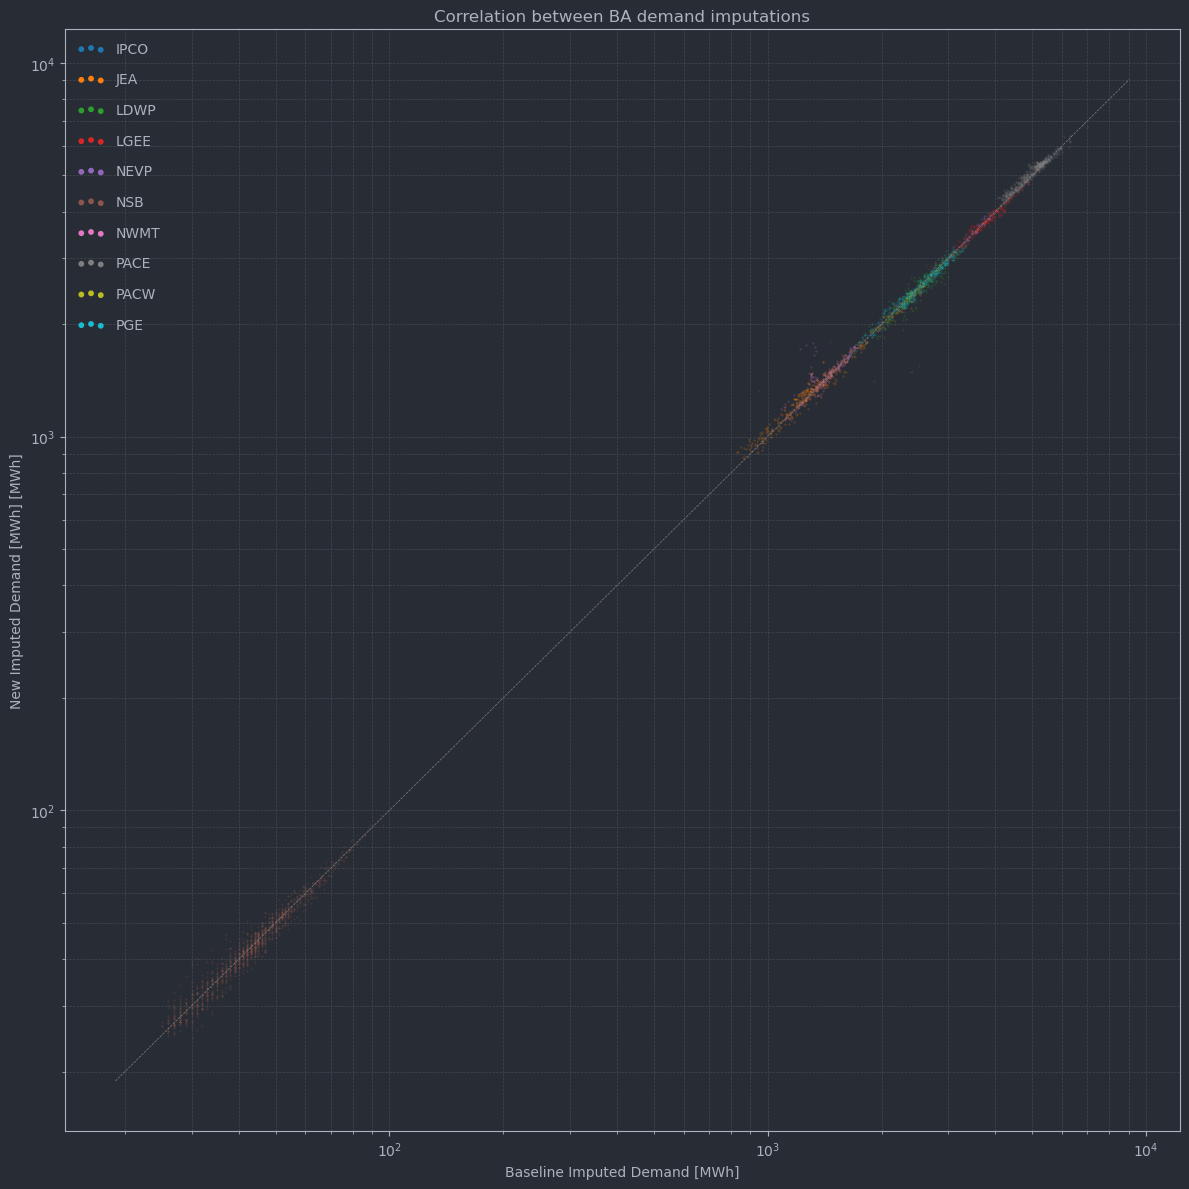

/tmp/ipykernel_5819/1230349378.py:26: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("tab10", len(idx_vals))


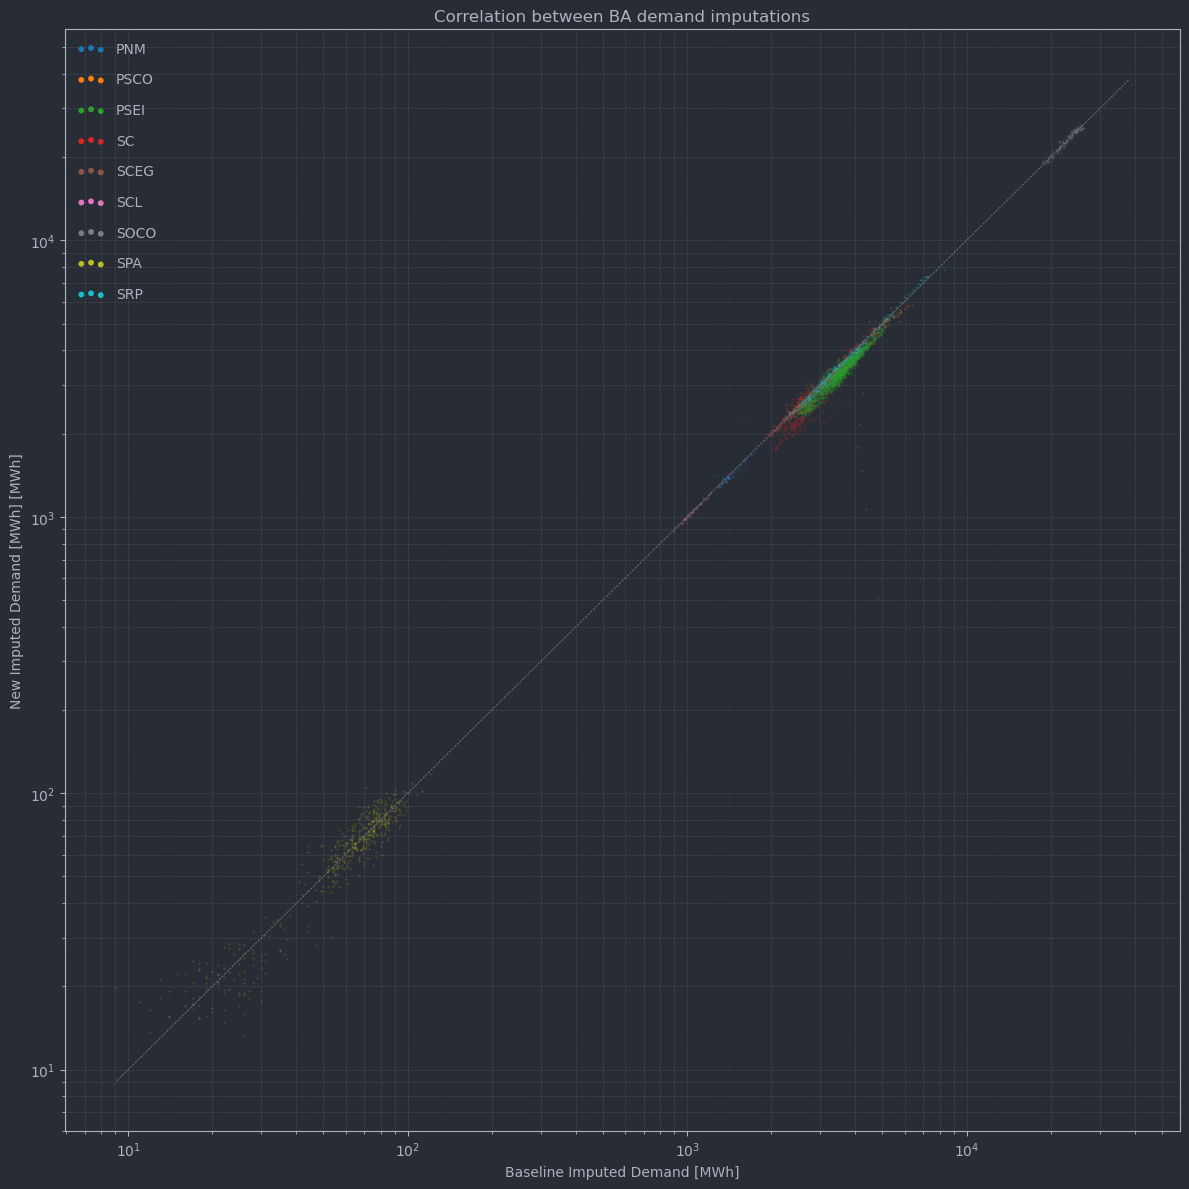

/tmp/ipykernel_5819/1230349378.py:26: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("tab10", len(idx_vals))


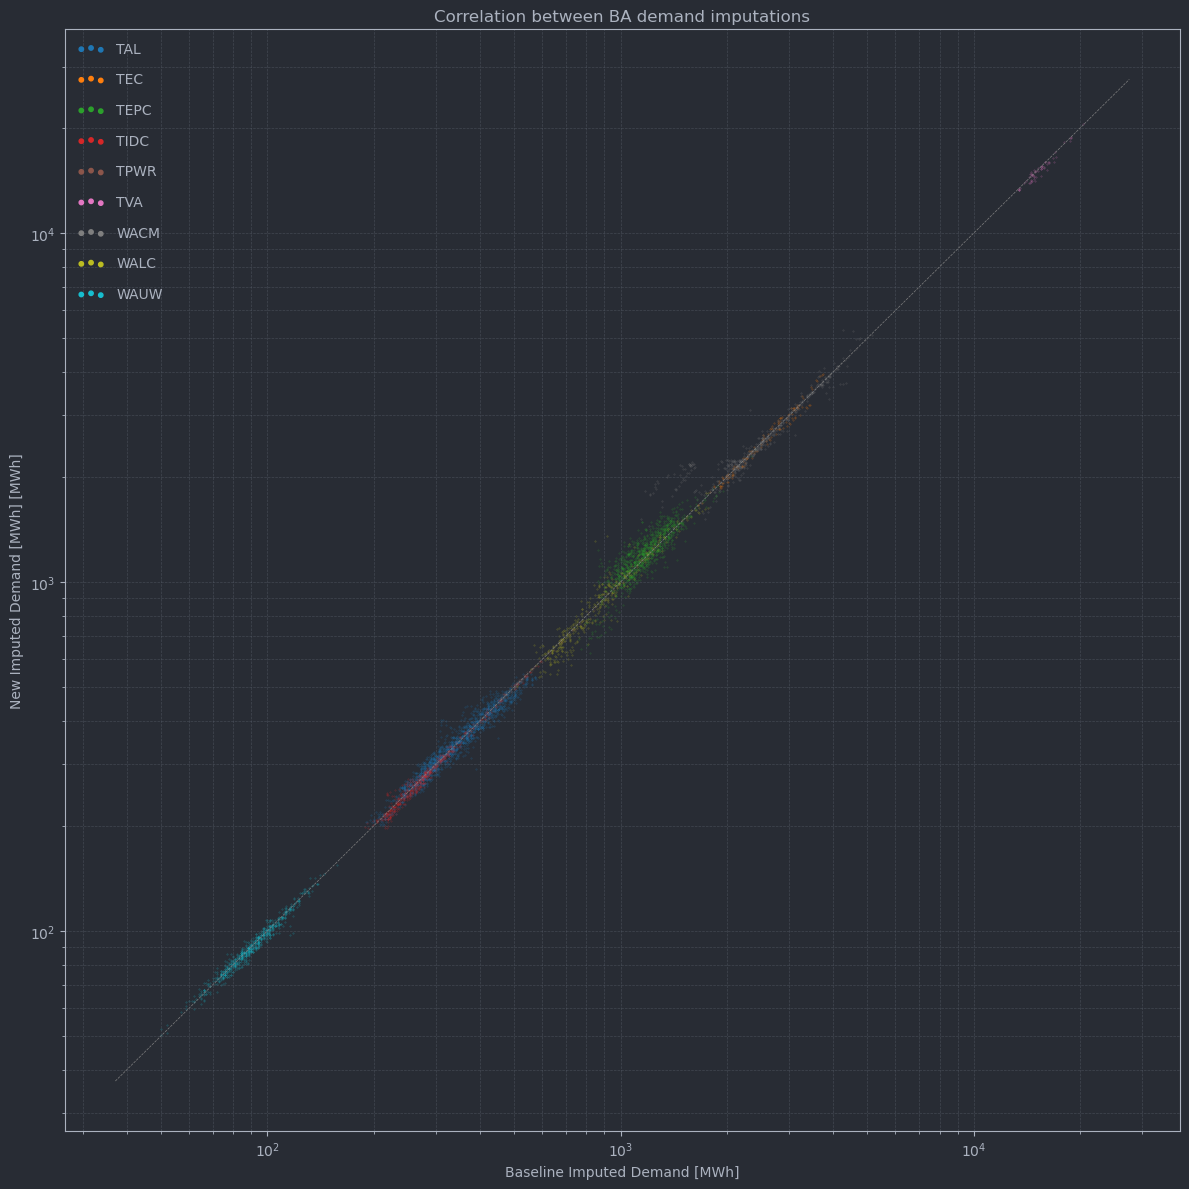

In [25]:
all_bas = list(ba_comparison_df["balancing_authority_code_eia"].unique())
for bas in np.array_split(all_bas, 5):
    plot_correlation(
        ba_comparison_df[ba_comparison_df.demand_imputed_pudl_mwh_imputation_code.notnull()].reset_index(),
        idx_cols=["balancing_authority_code_eia"],
        idx_vals=bas,
        timeseries_x="baseline_demand_mwh",
        timeseries_y="demand_imputed_pudl_mwh",
        xlabel="Baseline Imputed Demand [MWh]",
        ylabel="New Imputed Demand [MWh] [MWh]",
        title="Correlation between BA demand imputations",
        alpha=0.4,
    )

## Look for Anomalies

### Define functions for identifying concerning sections of data
To identify cases similar to the CISO-PGAE data highlighted above, one potential approach could be to look for instances where the interquantile range (IQR) over a small timeframe is significantly different from the interquantile range of a larger timeframe. This approach is driven by our observations of the plot above where we the amplitude of our imputed sections is significantly smaller than the amplitude of the rest of the data.

Below is a function that will help to identify cases which follow this pattern. This function works by computing the IQR over two rolling windows, with one larger window and one smaller. It then computes the relative difference between these IQRs to find cases where the amplitude changes rapidly.

In [26]:
def _rolling_window_stats(
    id_groups,
    demand_col: str,
    upper_quantile: float = 0.95,
    lower_quantile: float = 0.05,
    window: int = 48,
    window_prefix: str = "small",
):
    """Compute IQR over a specified window size."""
    rolling_lower_quantile = id_groups.rolling(window).quantile(lower_quantile).rename(
        columns={
            demand_col: f"{window_prefix}_window_lower_quantile",
        }
    )
    rolling_upper_quantile = id_groups.rolling(window).quantile(upper_quantile).rename(
        columns={
            demand_col: f"{window_prefix}_window_upper_quantile",
        }
    )
    rolling_stats = pd.concat([rolling_lower_quantile, rolling_upper_quantile], axis="columns")
    rolling_stats[f"{window_prefix}_window_iqr"] = (
        rolling_stats[f"{window_prefix}_window_upper_quantile"] - rolling_stats[f"{window_prefix}_window_lower_quantile"]
    )
    return rolling_stats


def detect_problem_cases(
    df: pd.DataFrame,
    idx_cols: list[str],
    time_col: str = "datetime_utc",
    reported_demand_col: str = "demand_reported_mwh",
    imputed_demand_col: str = "demand_imputed_pudl_mwh",
    flag_col: str = "demand_imputed_pudl_mwh_imputation_code",
    upper_quantile: float = 0.95,
    lower_quantile: float = 0.05,
    small_window: int = 72,
    large_window: int = 96,
):
    """Compute IQR over two overlapping windows and find relative difference between the two."""
    # Group by ID to compute rolling window IQRs
    id_groups_a = df.groupby(by=idx_cols)[[reported_demand_col, imputed_demand_col]]
    id_groups_b = df[df[flag_col].isnull()].groupby(by=idx_cols)[[reported_demand_col, imputed_demand_col]]
    small_window_stats = _rolling_window_stats(
        id_groups=id_groups_a,
        demand_col=imputed_demand_col,
        upper_quantile=upper_quantile,
        lower_quantile=lower_quantile,
        window=small_window,
    )
    large_window_stats = _rolling_window_stats(
        id_groups=id_groups_b,
        demand_col=reported_demand_col,
        upper_quantile=upper_quantile,
        lower_quantile=lower_quantile,
        window=large_window,
        window_prefix="large",
    )

    # Create a single dataframe with large/small window IQRs
    window_stats = pd.concat(
        [
            df[[*idx_cols, time_col]],
            small_window_stats.reset_index(level=idx_cols, drop=True),
            large_window_stats.reset_index(level=idx_cols, drop=True),
        ], axis="columns"
    )

    # Compute relative difference between IQR
    window_stats["iqr_relative_diff"] = (
        abs(window_stats["large_window_iqr"] - window_stats["small_window_iqr"]) / (window_stats["large_window_iqr"] + window_stats["small_window_iqr"])
    )

    # Drop rows with low magnitude, as this data is typically much messier
    window_stats = window_stats[window_stats["large_window_lower_quantile"] > 100]

    # Sort values then drop duplicates on ID and month datetime falls within
    # This stops from reporting many hours from the same case
    window_stats["month"] = window_stats[time_col].dt.to_period("M")
    return window_stats.sort_values(by="iqr_relative_diff", ascending=False).drop_duplicates(subset=[*idx_cols, "month"])

### Investigate subregion data

Now plot all instances where relative difference is greater than 0.6.

/tmp/ipykernel_5819/3127256432.py:41: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  id_groups_a = df.groupby(by=idx_cols)[[reported_demand_col, imputed_demand_col]]
/tmp/ipykernel_5819/3127256432.py:42: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  id_groups_b = df[df[flag_col].isnull()].groupby(by=idx_cols)[[reported_demand_col, imputed_demand_col]]


balancing_authority_code_eia                             CISO
balancing_authority_subregion_code_eia                   PGAE
datetime_utc                              2019-03-18 20:00:00
demand_reported_mwh                                    7017.0
small_window_lower_quantile                       7006.457373
demand_reported_mwh                                    7017.0
small_window_upper_quantile                       7670.313257
small_window_iqr                                   663.855884
large_window_lower_quantile                            6701.5
demand_imputed_pudl_mwh                                6701.5
large_window_upper_quantile                          12397.75
demand_imputed_pudl_mwh                              12397.75
large_window_iqr                                      5696.25
iqr_relative_diff                                    0.791244
month                                                 2019-03
Name: 7340, dtype: object


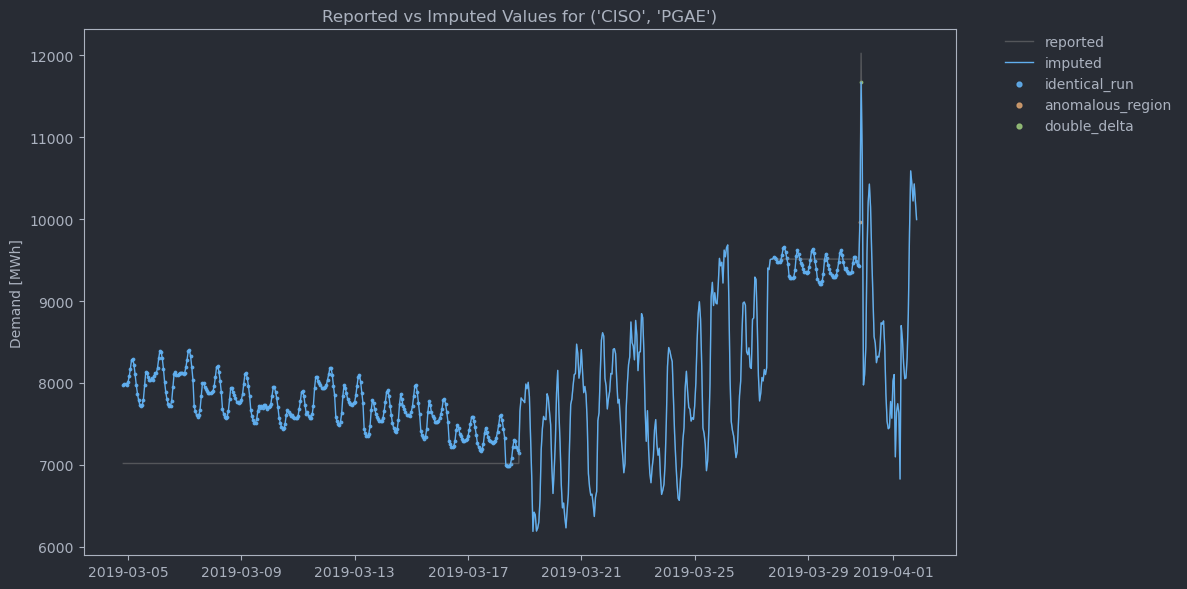

balancing_authority_code_eia                             SWPP
balancing_authority_subregion_code_eia                     WR
datetime_utc                              2019-04-29 10:00:00
demand_reported_mwh                                    3159.8
small_window_lower_quantile                            3159.8
demand_reported_mwh                                   3294.45
small_window_upper_quantile                           3294.45
small_window_iqr                                       134.65
large_window_lower_quantile                           2548.25
demand_imputed_pudl_mwh                               2548.25
large_window_upper_quantile                           3429.75
demand_imputed_pudl_mwh                               3429.75
large_window_iqr                                        881.5
iqr_relative_diff                                     0.73498
month                                                 2019-04
Name: 334864, dtype: object


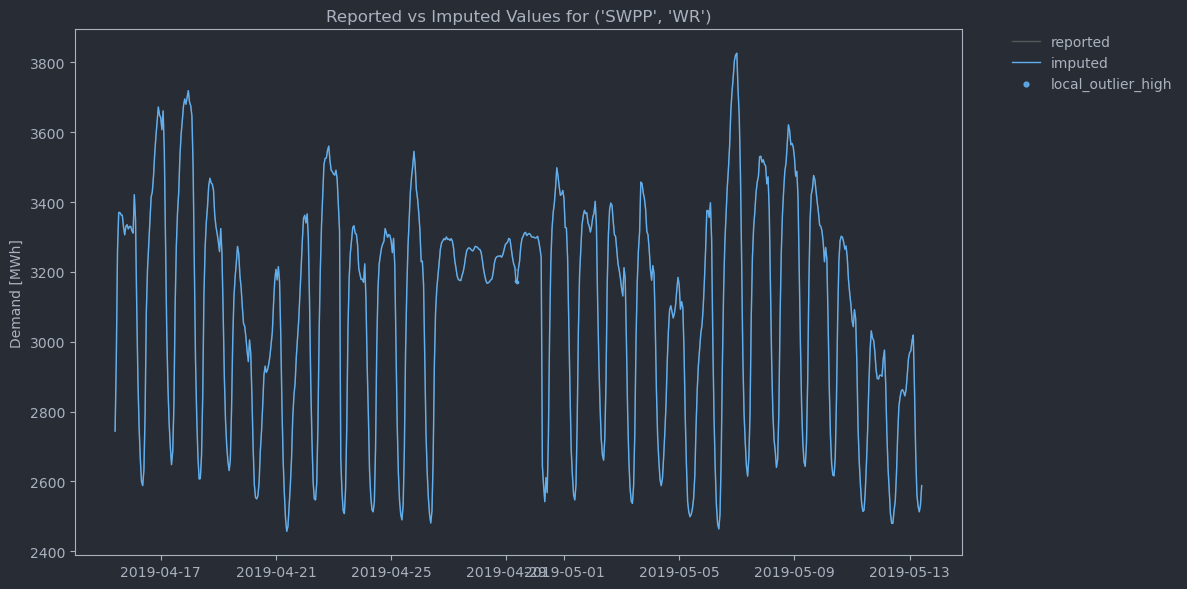

balancing_authority_code_eia                             SWPP
balancing_authority_subregion_code_eia                     WR
datetime_utc                              2019-03-22 02:00:00
demand_reported_mwh                                   2811.45
small_window_lower_quantile                       2840.534656
demand_reported_mwh                                   3584.75
small_window_upper_quantile                            3588.8
small_window_iqr                                   748.265344
large_window_lower_quantile                            3326.5
demand_imputed_pudl_mwh                           3326.500061
large_window_upper_quantile                            3474.5
demand_imputed_pudl_mwh                           3474.499939
large_window_iqr                                        148.0
iqr_relative_diff                                    0.669741
month                                                 2019-03
Name: 319224, dtype: object


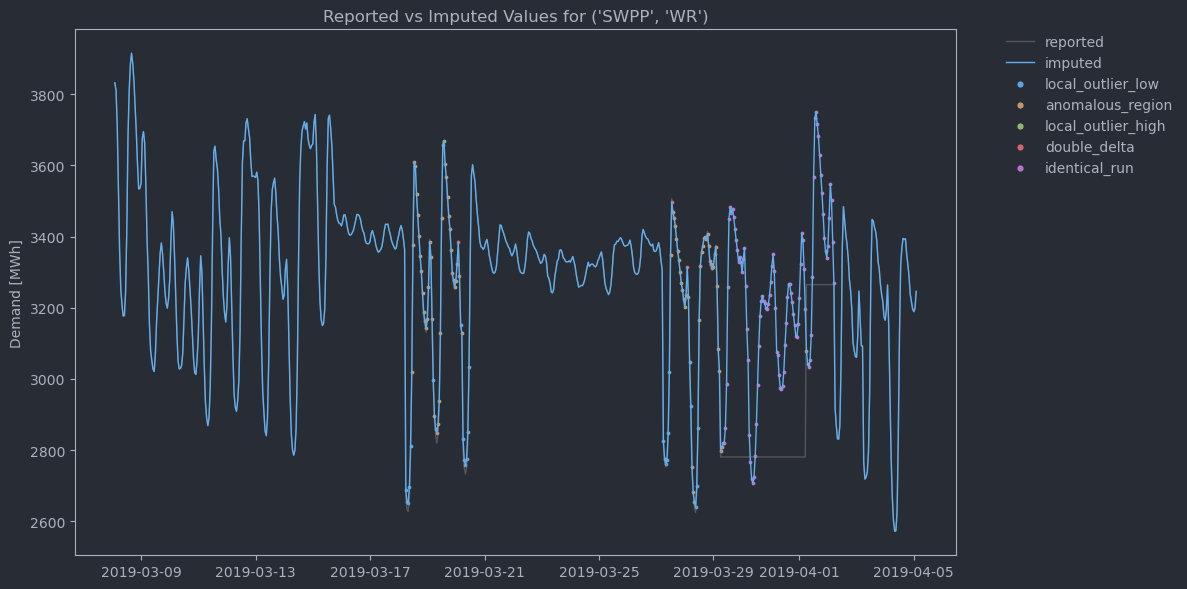

balancing_authority_code_eia                             SWPP
balancing_authority_subregion_code_eia                    LES
datetime_utc                              2023-12-15 12:00:00
demand_reported_mwh                                    433.55
small_window_lower_quantile                        433.550458
demand_reported_mwh                                    459.45
small_window_upper_quantile                        459.788754
small_window_iqr                                    26.238297
large_window_lower_quantile                            342.75
demand_imputed_pudl_mwh                            342.749336
large_window_upper_quantile                             460.5
demand_imputed_pudl_mwh                             460.50029
large_window_iqr                                       117.75
iqr_relative_diff                                     0.63555
month                                                 2023-12
Name: 3630547, dtype: object


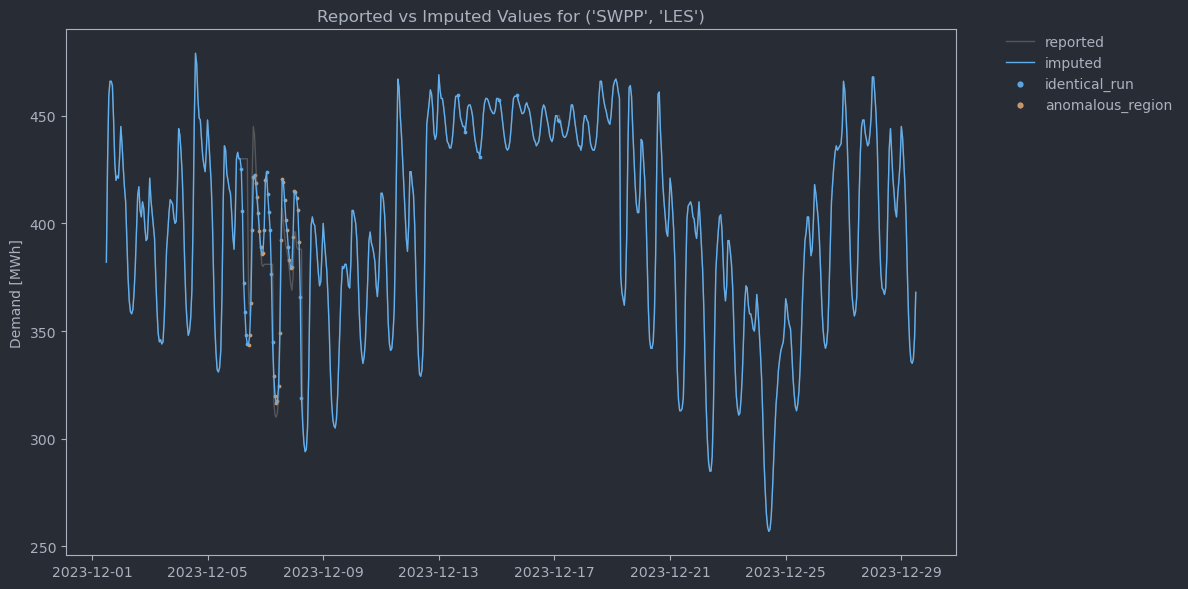

balancing_authority_code_eia                             SWPP
balancing_authority_subregion_code_eia                   WFEC
datetime_utc                              2024-01-20 11:00:00
demand_reported_mwh                                    1070.1
small_window_lower_quantile                       1070.100134
demand_reported_mwh                                   1732.45
small_window_upper_quantile                       1612.608929
small_window_iqr                                   542.508795
large_window_lower_quantile                            1072.5
demand_imputed_pudl_mwh                           1072.500153
large_window_upper_quantile                            1204.0
demand_imputed_pudl_mwh                                1204.0
large_window_iqr                                        131.5
iqr_relative_diff                                    0.609797
month                                                 2024-01
Name: 3933464, dtype: object


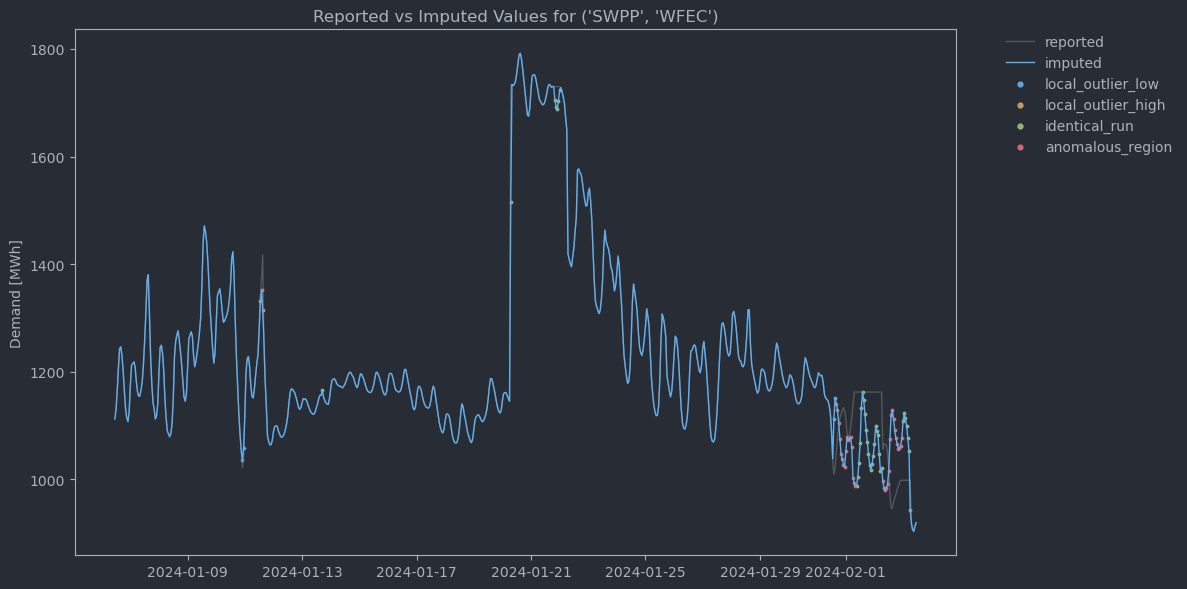

In [27]:
df = detect_problem_cases(eia930_subregion_demand, subregion_idx_cols)
for _, row in df[df["iqr_relative_diff"] > 0.6].iterrows():
    print(row)
    plot_imputation(
        eia930_subregion_demand,
        idx_cols=subregion_idx_cols,
        idx_vals=(row.balancing_authority_code_eia, row.balancing_authority_subregion_code_eia),
        start_date=row.datetime_utc - timedelta(weeks=2),
        end_date=row.datetime_utc + timedelta(weeks=2),
        reported_col="demand_reported_mwh",
        imputed_col="demand_imputed_pudl_mwh",
    )

Looking at the top regions identified here, it looks like this metric is quite effective at identifying regions of data with characteristics similar to the PG&E example that initially spurred this analysis. However, in all cases except the PG&E case, the questionable change in amplitude is caused by the reported data, not our imputation. While we would still like to better understand why our imputation method is behaving this way in this specific case, the fact that it does not seem to be a widespread problem, and that similar anomalous sections show up in reported data does give us more confidence that this is not a major systemic issue.

### Investigate BA level data

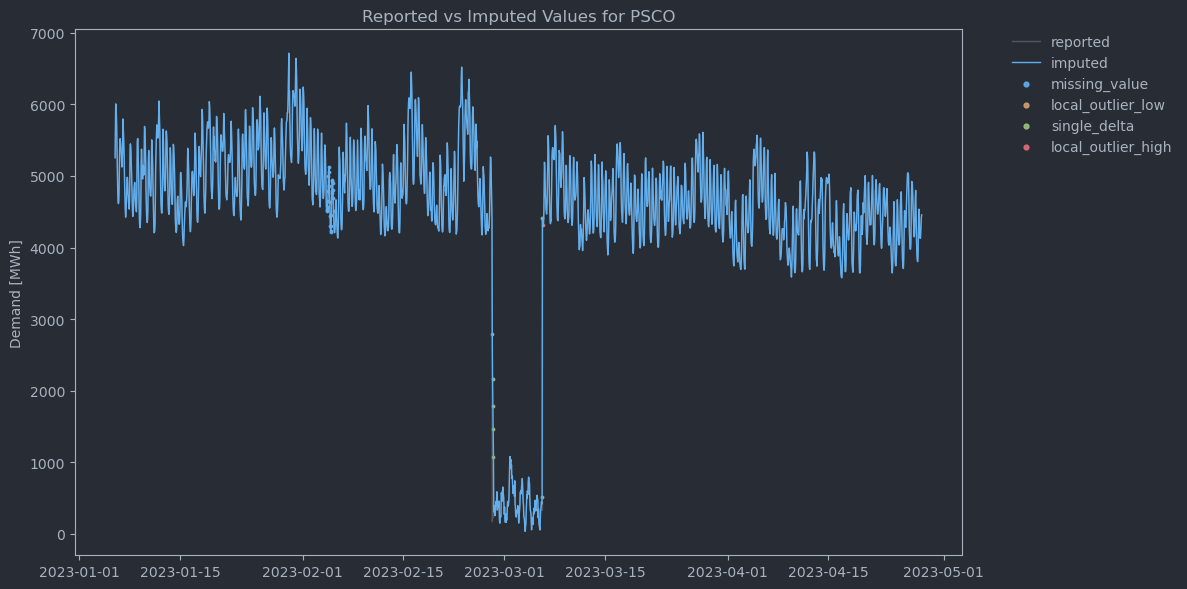

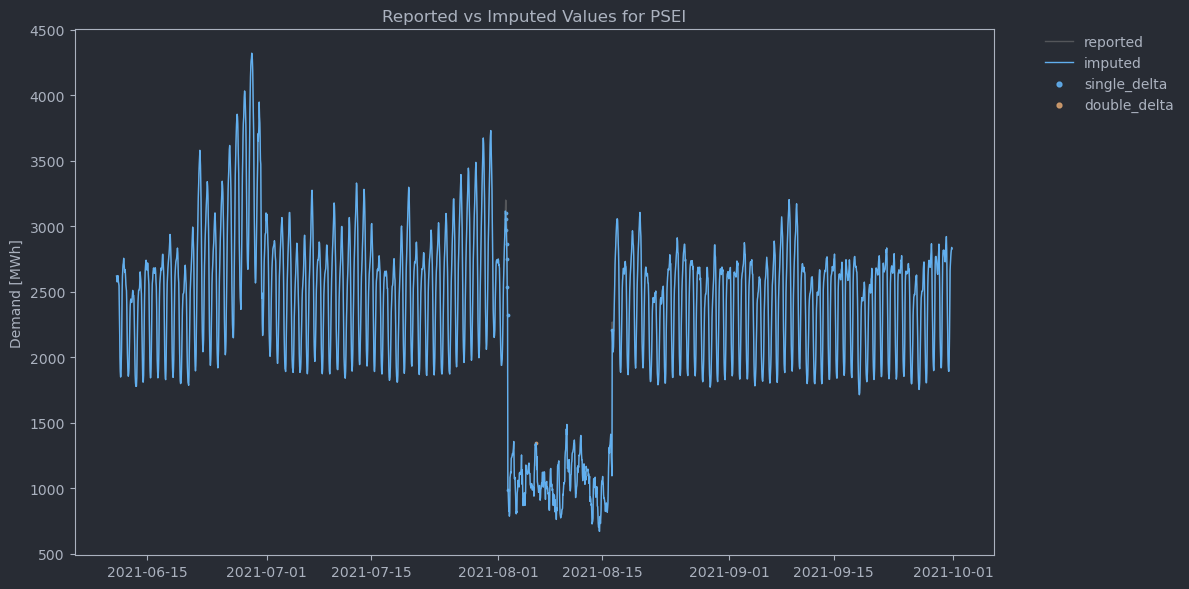

In [28]:
df = detect_problem_cases(eia930_ba_demand, ba_idx_cols)
for _, row in df[df["iqr_relative_diff"] > 0.6].iterrows():
    plot_imputation(
        eia930_ba_demand,
        idx_cols=ba_idx_cols,
        idx_vals=(row.balancing_authority_code_eia),
        start_date=row.datetime_utc - timedelta(weeks=8),
        end_date=row.datetime_utc + timedelta(weeks=8),
        reported_col="demand_reported_mwh",
        imputed_col="demand_imputed_pudl_mwh",
    )

In this BA level data we see two particularly pronounced examples of the phenomenon, but in both cases it's present in the underlying data, not introduced by our imputation. That being said, these sections of data look pretty unexpected, and we may want our flagging to catch these to try to fix this behavior. For that reason, we'll compare to the baseline below to see if they had different results. We don't expect any differences in flagging, but if there were, it could indicate a bug in our flagging implementation. 

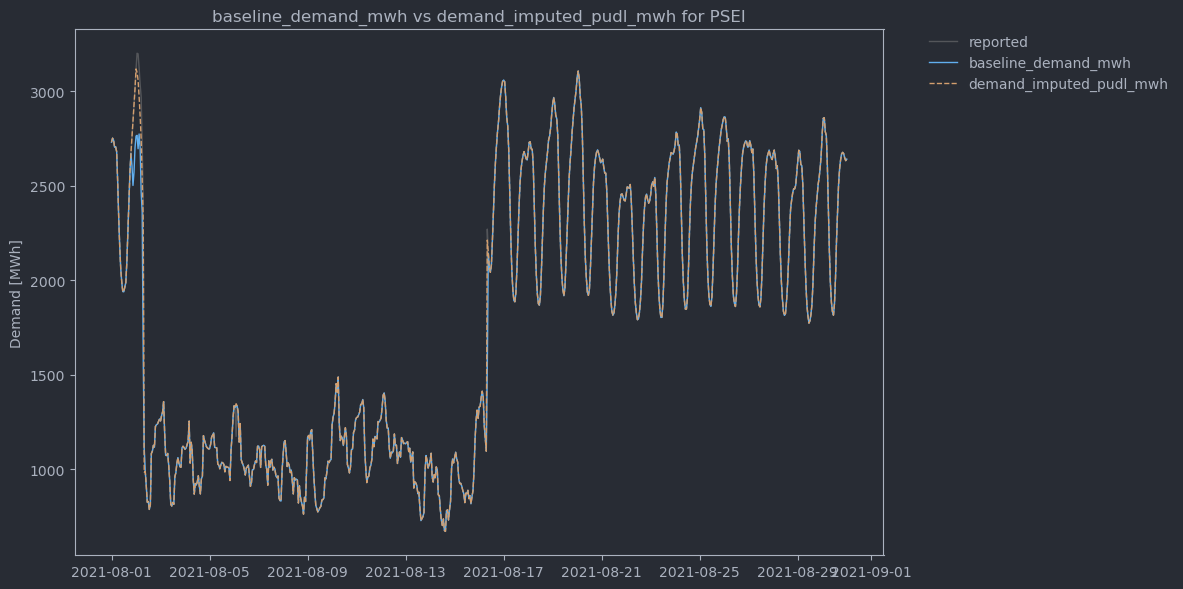

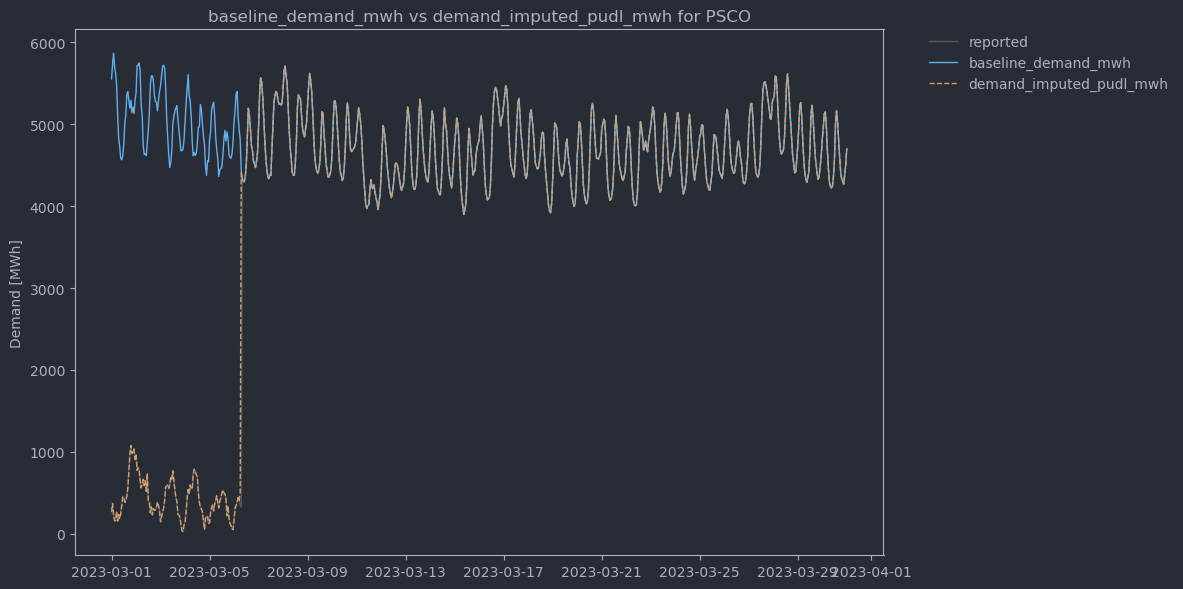

In [29]:
for month, ba_idx_vals in [
    ("2021-08-01", ("PSEI")),
    ("2023-03-01", ("PSCO")),
]:
    plot_compare_imputation(
        ba_comparison_df,
        idx_cols=ba_idx_cols,
        idx_vals=ba_idx_vals,
        start_date=month,
        end_date=pd.Timestamp(month) + MonthEnd(),
        timeseries_a="baseline_demand_mwh",
        timeseries_b="demand_imputed_pudl_mwh",
        reported_col="demand_reported_mwh",
    )

While our results are very similar in the top plot, the anomalous behavior does not appear in the bottom. At first we assumed this was an issue with our flagging, but after further investigation, we found that this section of data is entirely NULL in the raw EIA data they used.